In [1]:
!nvidia-smi

Thu Feb 29 16:12:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   29C    P8              21W / 215W |   1247MiB /  8192MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/data_preprocessed/crema_d/preprocessed/'

In [8]:
sr = 16000

data_x = np.load(f'{data_dir}crema_d.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}crema_d.label_emotion.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
print(data_x.shape)
print(data_y.shape)
np.unique(data_y)

(7438,)
(7438,)


array([0, 1, 2, 3, 4, 5], dtype=int16)

In [9]:
classnames

array(['NEU', 'HAP', 'SAD', 'ANG', 'FEA', 'DIS'], dtype='<U3')

In [10]:
labels = ['ANG', 'NEU', 'SAD', 'HAP']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_y = [label_to_index(idx) for idx in data_y[filtered_idx]]
print(data_x.shape)

(4898,)


In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3918
Test: 980


In [12]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.).permute(0, 2, 1)
    return batch

def collate_fn(batch, max_duration_in_second=3, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            waveform = np.array(waveform, dtype=float).squeeze()
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(waveform, dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [24]:
from IConNet.nn.model import M13sinc as M13

In [18]:
from omegaconf import OmegaConf as ocf

In [19]:
import traceback

In [25]:
model_config_path = 'config/model/m14sinc.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M14sinc', 'description': 'FirConv with fftconv', 'fe': {'n_block': 2, 'n_channel': [198, 30], 'kernel_size': [511, 127], 'stride': [2, 4], 'window_k': [5, 9], 'residual_connection_type': 'stack', 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': True, 'learnable_windows': False, 'shared_window': True, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}

In [26]:
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

M13sinc(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (no

In [27]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [28]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [29]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                 | 0.003278688524590164/10 [00:00<35:19, 212.01s/it]

Train Epoch: 1 [0/3918 (0%)]	Loss: 1.554227
Mem before-during-after: 1692160 3965101568 26915328


  1%|▍                                 | 0.13442622950819672/10 [00:17<23:36, 143.60s/it]

Train Epoch: 1 [640/3918 (16%)]	Loss: 2.141518
Mem before-during-after: 27466240 3980478464 26915328


  3%|▉                                 | 0.26557377049180286/10 [00:34<22:48, 140.61s/it]

Train Epoch: 1 [1280/3918 (33%)]	Loss: 1.476676
Mem before-during-after: 26915328 3980690432 26915328


  4%|█▍                                   | 0.39672131147541/10 [00:51<22:30, 140.64s/it]

Train Epoch: 1 [1920/3918 (49%)]	Loss: 1.591426
Mem before-during-after: 27796992 3981023744 27796992


  5%|█▊                                 | 0.5278688524590167/10 [01:08<18:42, 118.53s/it]

Train Epoch: 1 [2560/3918 (66%)]	Loss: 1.308199
Mem before-during-after: 27040256 3981381120 26915328


  7%|██▎                                | 0.6590163934426216/10 [01:25<22:04, 141.82s/it]

Train Epoch: 1 [3200/3918 (82%)]	Loss: 1.435166
Mem before-during-after: 27796992 3597960704 26915328


  8%|██▊                                | 0.7901639344262266/10 [01:42<25:02, 163.16s/it]

Train Epoch: 1 [3840/3918 (98%)]	Loss: 1.442664
Mem before-during-after: 26915328 3981007872 26915328


 10%|███▌                                | 0.9999999999999944/10 [01:57<10:17, 68.62s/it]


Test Epoch: 1	Accuracy: 254/976 (26%)



 10%|███▌                                | 1.0032786885245846/10 [01:57<12:22, 82.56s/it]

Train Epoch: 2 [0/3918 (0%)]	Loss: 1.440032
Mem before-during-after: 26914304 3978256896 26915328


 11%|███▉                               | 1.1344262295081895/10 [02:13<22:37, 153.10s/it]

Train Epoch: 2 [640/3918 (16%)]	Loss: 1.583569
Mem before-during-after: 27348480 3980374528 26915328


 13%|████▍                              | 1.2655737704917944/10 [02:30<19:19, 132.79s/it]

Train Epoch: 2 [1280/3918 (33%)]	Loss: 1.680370
Mem before-during-after: 26915328 3980374528 27040256


 14%|████▉                              | 1.3967213114753994/10 [02:48<19:54, 138.84s/it]

Train Epoch: 2 [1920/3918 (49%)]	Loss: 1.398175
Mem before-during-after: 26915328 3980374528 26915328


 15%|█████▎                             | 1.5278688524590043/10 [03:04<17:10, 121.65s/it]

Train Epoch: 2 [2560/3918 (66%)]	Loss: 1.369875
Mem before-during-after: 26915328 3982147072 26915328


 17%|█████▊                             | 1.6590163934426092/10 [03:22<19:18, 138.90s/it]

Train Epoch: 2 [3200/3918 (82%)]	Loss: 1.368247
Mem before-during-after: 26915328 3980374528 26915328


 18%|██████▎                            | 1.7901639344262141/10 [03:40<18:38, 136.20s/it]

Train Epoch: 2 [3840/3918 (98%)]	Loss: 1.406646
Mem before-during-after: 27040256 3981889536 26915328


 20%|███████▍                             | 1.999999999999982/10 [03:54<08:55, 66.97s/it]


Test Epoch: 2	Accuracy: 254/976 (26%)



 20%|███████▏                            | 2.0032786885245724/10 [03:55<11:18, 84.81s/it]

Train Epoch: 3 [0/3918 (0%)]	Loss: 1.556347
Mem before-during-after: 26914304 3978256384 26915328


 21%|███████▍                           | 2.1344262295081773/10 [04:10<15:12, 115.99s/it]

Train Epoch: 3 [640/3918 (16%)]	Loss: 1.350867
Mem before-during-after: 26915328 3980049920 26915328


 23%|████████▏                           | 2.265573770491782/10 [04:26<15:17, 118.57s/it]

Train Epoch: 3 [1280/3918 (33%)]	Loss: 1.415972
Mem before-during-after: 26915328 3596953600 26915328


 24%|████████▋                           | 2.396721311475387/10 [04:43<16:37, 131.22s/it]

Train Epoch: 3 [1920/3918 (49%)]	Loss: 1.336844
Mem before-during-after: 26915328 3979735552 26915328


 25%|█████████                           | 2.527868852458992/10 [04:59<14:42, 118.07s/it]

Train Epoch: 3 [2560/3918 (66%)]	Loss: 1.370390
Mem before-during-after: 26915328 3980374528 26915328


 27%|█████████▌                          | 2.659016393442597/10 [05:15<17:19, 141.66s/it]

Train Epoch: 3 [3200/3918 (82%)]	Loss: 1.376228
Mem before-during-after: 26915328 3980699136 26915328


 28%|██████████                          | 2.790163934426202/10 [05:32<13:49, 115.01s/it]

Train Epoch: 3 [3840/3918 (98%)]	Loss: 1.364376
Mem before-during-after: 26915328 3981332992 26915328


 30%|███████████▍                          | 2.99999999999997/10 [05:47<07:41, 66.00s/it]


Test Epoch: 3	Accuracy: 252/976 (26%)



 30%|███████████▍                          | 3.00327868852456/10 [05:47<09:23, 80.50s/it]

Train Epoch: 4 [0/3918 (0%)]	Loss: 1.988927
Mem before-during-after: 26914304 3978256896 26915328


 31%|███████████▎                        | 3.134426229508165/10 [06:03<13:04, 114.31s/it]

Train Epoch: 4 [640/3918 (16%)]	Loss: 1.378913
Mem before-during-after: 26915328 3953469440 26915328


 33%|████████████                         | 3.26557377049177/10 [06:18<12:49, 114.20s/it]

Train Epoch: 4 [1280/3918 (33%)]	Loss: 1.383344
Mem before-during-after: 26915328 3980049920 26915328


 34%|███████████▉                       | 3.3967213114753747/10 [06:35<13:38, 123.99s/it]

Train Epoch: 4 [1920/3918 (49%)]	Loss: 1.444265
Mem before-during-after: 27796992 3771930624 26915328


 35%|████████████▎                      | 3.5278688524589796/10 [06:53<15:39, 145.23s/it]

Train Epoch: 4 [2560/3918 (66%)]	Loss: 1.536037
Mem before-during-after: 27796992 3980142080 26915328


 37%|████████████▊                      | 3.6590163934425846/10 [07:10<13:13, 125.15s/it]

Train Epoch: 4 [3200/3918 (82%)]	Loss: 1.533149
Mem before-during-after: 26915328 3980049920 26915328


 38%|█████████████▎                     | 3.7901639344261895/10 [07:28<14:12, 137.27s/it]

Train Epoch: 4 [3840/3918 (98%)]	Loss: 1.375192
Mem before-during-after: 27796992 3980142080 26915328


 40%|██████████████▍                     | 3.9999999999999574/10 [07:43<06:31, 65.29s/it]


Test Epoch: 4	Accuracy: 254/976 (26%)



 40%|██████████████▍                     | 4.0032786885245475/10 [07:43<08:24, 84.11s/it]

Train Epoch: 5 [0/3918 (0%)]	Loss: 1.391557
Mem before-during-after: 26914304 3978256384 26915328


 41%|██████████████▉                     | 4.134426229508152/10 [08:00<13:27, 137.65s/it]

Train Epoch: 5 [640/3918 (16%)]	Loss: 1.421576
Mem before-during-after: 26915328 3953398272 26915328


 43%|███████████████▎                    | 4.265573770491757/10 [08:18<13:09, 137.60s/it]

Train Epoch: 5 [1280/3918 (33%)]	Loss: 1.300781
Mem before-during-after: 26915328 3980374528 26915328


 44%|███████████████▊                    | 4.396721311475362/10 [08:33<10:46, 115.43s/it]

Train Epoch: 5 [1920/3918 (49%)]	Loss: 1.372240
Mem before-during-after: 26915328 3980049920 26915328


 45%|████████████████▎                   | 4.527868852458967/10 [08:48<11:09, 122.30s/it]

Train Epoch: 5 [2560/3918 (66%)]	Loss: 1.414834
Mem before-during-after: 26915328 3854770176 27348480


 47%|████████████████▊                   | 4.659016393442572/10 [09:05<13:17, 149.27s/it]

Train Epoch: 5 [3200/3918 (82%)]	Loss: 1.376642
Mem before-during-after: 26915328 3981023744 27796992


 48%|█████████████████▏                  | 4.790163934426177/10 [09:24<12:20, 142.10s/it]

Train Epoch: 5 [3840/3918 (98%)]	Loss: 1.429950
Mem before-during-after: 27348480 3980049920 27040256


 50%|██████████████████▍                  | 4.999999999999945/10 [09:38<05:35, 67.05s/it]


Test Epoch: 5	Accuracy: 252/976 (26%)



 50%|██████████████████▌                  | 5.003278688524535/10 [09:39<06:52, 82.50s/it]

Train Epoch: 6 [0/3918 (0%)]	Loss: 1.393521
Mem before-during-after: 26914304 3978256896 26915328


 51%|██████████████████▉                  | 5.13442622950814/10 [09:54<10:17, 126.97s/it]

Train Epoch: 6 [640/3918 (16%)]	Loss: 1.382530
Mem before-during-after: 26915328 3980049920 26915328


 53%|██████████████████▉                 | 5.265573770491745/10 [10:12<09:16, 117.52s/it]

Train Epoch: 6 [1280/3918 (33%)]	Loss: 5.084720
Mem before-during-after: 26915328 3980374528 26915328


 54%|███████████████████▉                 | 5.39672131147535/10 [10:28<11:14, 146.57s/it]

Train Epoch: 6 [1920/3918 (49%)]	Loss: 1.435733
Mem before-during-after: 26915328 3772590592 27833856


 55%|███████████████████▉                | 5.527868852458955/10 [10:46<10:17, 137.99s/it]

Train Epoch: 6 [2560/3918 (66%)]	Loss: 1.398084
Mem before-during-after: 27348480 3980049920 27040256


 57%|████████████████████▉                | 5.65901639344256/10 [11:04<10:30, 145.31s/it]

Train Epoch: 6 [3200/3918 (82%)]	Loss: 1.520391
Mem before-during-after: 26915328 3980374528 26915328


 58%|████████████████████▊               | 5.790163934426165/10 [11:22<08:08, 115.94s/it]

Train Epoch: 6 [3840/3918 (98%)]	Loss: 1.365720
Mem before-during-after: 26915328 3982147072 26915328


 60%|█████████████████████▌              | 5.9999999999999325/10 [11:36<04:30, 67.71s/it]


Test Epoch: 6	Accuracy: 254/976 (26%)



 60%|██████████████████████▏              | 6.003278688524523/10 [11:37<05:36, 84.31s/it]

Train Epoch: 7 [0/3918 (0%)]	Loss: 1.334023
Mem before-during-after: 26914304 3978256896 26915328


 61%|█████████████████████▍             | 6.1344262295081275/10 [11:55<08:59, 139.52s/it]

Train Epoch: 7 [640/3918 (16%)]	Loss: 1.340463
Mem before-during-after: 26915328 3980699136 26915328


 63%|█████████████████████▉             | 6.2655737704917325/10 [12:13<07:43, 124.24s/it]

Train Epoch: 7 [1280/3918 (33%)]	Loss: 1.485055
Mem before-during-after: 26915328 3980049920 26915328


 64%|███████████████████████             | 6.396721311475337/10 [12:30<07:46, 129.52s/it]

Train Epoch: 7 [1920/3918 (49%)]	Loss: 1.349729
Mem before-during-after: 27796992 3980699136 26915328


 65%|███████████████████████▌            | 6.527868852458942/10 [12:46<08:00, 138.43s/it]

Train Epoch: 7 [2560/3918 (66%)]	Loss: 1.417638
Mem before-during-after: 26915328 3980374528 26915328


 67%|███████████████████████▉            | 6.659016393442547/10 [13:05<07:58, 143.31s/it]

Train Epoch: 7 [3200/3918 (82%)]	Loss: 1.403141
Mem before-during-after: 26915328 3981023744 27796992


 68%|████████████████████████▍           | 6.790163934426152/10 [13:24<09:01, 168.71s/it]

Train Epoch: 7 [3840/3918 (98%)]	Loss: 1.606531
Mem before-during-after: 26915328 3980551680 26915328


 70%|██████████████████████████▌           | 6.99999999999992/10 [13:39<03:50, 76.74s/it]


Test Epoch: 7	Accuracy: 254/976 (26%)



 70%|██████████████████████████▌           | 7.00327868852451/10 [13:39<04:36, 92.25s/it]

Train Epoch: 8 [0/3918 (0%)]	Loss: 1.403980
Mem before-during-after: 26914304 3978256896 26915328


 71%|█████████████████████████▋          | 7.134426229508115/10 [13:55<06:10, 129.22s/it]

Train Epoch: 8 [640/3918 (16%)]	Loss: 1.398009
Mem before-during-after: 26915328 3980126720 26915328


 73%|██████████████████████████▉          | 7.26557377049172/10 [14:11<06:24, 140.78s/it]

Train Epoch: 8 [1280/3918 (33%)]	Loss: 1.399917
Mem before-during-after: 26915328 3982471680 26915328


 74%|██████████████████████████▋         | 7.396721311475325/10 [14:29<05:55, 136.61s/it]

Train Epoch: 8 [1920/3918 (49%)]	Loss: 1.448076
Mem before-during-after: 26915328 3980374528 26915328


 75%|███████████████████████████▊         | 7.52786885245893/10 [14:45<04:43, 114.69s/it]

Train Epoch: 8 [2560/3918 (66%)]	Loss: 1.365505
Mem before-during-after: 27796992 3980142080 26915328


 77%|███████████████████████████▌        | 7.659016393442535/10 [15:02<04:26, 113.70s/it]

Train Epoch: 8 [3200/3918 (82%)]	Loss: 1.408356
Mem before-during-after: 26915328 3980049920 26915328


 78%|████████████████████████████▊        | 7.79016393442614/10 [15:17<04:17, 116.39s/it]

Train Epoch: 8 [3840/3918 (98%)]	Loss: 1.386976
Mem before-during-after: 26915328 3980049920 26915328


 80%|█████████████████████████████▌       | 7.999999999999908/10 [15:32<02:10, 65.21s/it]


Test Epoch: 8	Accuracy: 254/976 (26%)



 80%|█████████████████████████████▌       | 8.003278688524498/10 [15:32<02:43, 82.12s/it]

Train Epoch: 9 [0/3918 (0%)]	Loss: 1.851825
Mem before-during-after: 26914304 3939779072 26915328


 81%|█████████████████████████████▎      | 8.134426229508103/10 [15:50<04:24, 141.69s/it]

Train Epoch: 9 [640/3918 (16%)]	Loss: 1.410361
Mem before-during-after: 26915328 3981580800 27796992


 83%|█████████████████████████████▊      | 8.265573770491708/10 [16:07<03:17, 114.12s/it]

Train Epoch: 9 [1280/3918 (33%)]	Loss: 1.370667
Mem before-during-after: 26915328 3980049920 26915328


 84%|██████████████████████████████▏     | 8.396721311475313/10 [16:25<03:42, 138.60s/it]

Train Epoch: 9 [1920/3918 (49%)]	Loss: 1.360458
Mem before-during-after: 26915328 3982796288 26915328


 85%|██████████████████████████████▋     | 8.527868852458917/10 [16:43<03:22, 137.35s/it]

Train Epoch: 9 [2560/3918 (66%)]	Loss: 1.377316
Mem before-during-after: 26915328 3981023744 27796992


 87%|███████████████████████████████▏    | 8.659016393442522/10 [17:00<03:03, 136.66s/it]

Train Epoch: 9 [3200/3918 (82%)]	Loss: 1.382688
Mem before-during-after: 26915328 3980699136 26915328


 88%|███████████████████████████████▋    | 8.790163934426127/10 [17:17<02:19, 115.65s/it]

Train Epoch: 9 [3840/3918 (98%)]	Loss: 1.384853
Mem before-during-after: 26915328 3980049920 26915328


 90%|█████████████████████████████████▎   | 8.999999999999895/10 [17:32<01:05, 65.49s/it]


Test Epoch: 9	Accuracy: 254/976 (26%)



 90%|█████████████████████████████████▎   | 9.003278688524485/10 [17:32<01:20, 81.18s/it]

Train Epoch: 10 [0/3918 (0%)]	Loss: 1.385276
Mem before-during-after: 26914304 3978256384 26915328


 91%|█████████████████████████████████▊   | 9.13442622950809/10 [17:48<02:00, 138.98s/it]

Train Epoch: 10 [640/3918 (16%)]	Loss: 1.412471
Mem before-during-after: 27796992 3980699136 26915328


 93%|█████████████████████████████████▎  | 9.265573770491695/10 [18:06<02:07, 174.24s/it]

Train Epoch: 10 [1280/3918 (33%)]	Loss: 1.361336
Mem before-during-after: 27585024 3979888640 26915328


 94%|███████████████████████████████████▋  | 9.3967213114753/10 [18:24<01:23, 138.15s/it]

Train Epoch: 10 [1920/3918 (49%)]	Loss: 1.418012
Mem before-during-after: 27796992 3981023744 27796992


 95%|██████████████████████████████████▎ | 9.527868852458905/10 [18:42<01:05, 138.31s/it]

Train Epoch: 10 [2560/3918 (66%)]	Loss: 1.383525
Mem before-during-after: 27796992 3981023744 27796992


 97%|███████████████████████████████████▋ | 9.65901639344251/10 [19:00<00:47, 138.44s/it]

Train Epoch: 10 [3200/3918 (82%)]	Loss: 1.369098
Mem before-during-after: 27796992 3980142080 26915328


 98%|███████████████████████████████████▏| 9.790163934426115/10 [19:19<00:29, 139.13s/it]

Train Epoch: 10 [3840/3918 (98%)]	Loss: 1.367156
Mem before-during-after: 27796992 3982239232 26915328


100%|███████████████████████████████████▉| 9.999999999999883/10 [19:33<00:00, 117.39s/it]


Test Epoch: 10	Accuracy: 254/976 (26%)



In [30]:
model_path = '../models_cremad4/cremad_label4_m14sinc_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [31]:
n_epoch = 10
n_epoch2 = 50
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4/cremad_label4_m14sinc_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                               | 0.003278688524590164/50 [00:00<1:45:55, 127.11s/it]

Train Epoch: 11 [0/3918 (0%)]	Loss: 1.395735
Mem before-during-after: 23740928 3975083008 26915328


  0%|                                | 0.13442622950819672/50 [00:17<2:18:58, 167.23s/it]

Train Epoch: 11 [640/3918 (16%)]	Loss: 1.414097
Mem before-during-after: 26915328 3980374528 26915328


  1%|▏                               | 0.26557377049180286/50 [00:36<1:37:56, 118.17s/it]

Train Epoch: 11 [1280/3918 (33%)]	Loss: 1.383572
Mem before-during-after: 26915328 3980049920 26915328


  1%|▎                                  | 0.39672131147541/50 [00:53<1:54:16, 138.23s/it]

Train Epoch: 11 [1920/3918 (49%)]	Loss: 1.382043
Mem before-during-after: 26915328 3980421120 26915328


  1%|▎                                | 0.5278688524590167/50 [01:10<1:55:12, 139.73s/it]

Train Epoch: 11 [2560/3918 (66%)]	Loss: 1.362530
Mem before-during-after: 26915328 3953949184 26915328


  1%|▍                                | 0.6590163934426216/50 [01:27<1:41:03, 122.90s/it]

Train Epoch: 11 [3200/3918 (82%)]	Loss: 1.355255
Mem before-during-after: 26915328 3980049920 26915328


  2%|▌                                | 0.7901639344262266/50 [01:42<1:35:49, 116.84s/it]

Train Epoch: 11 [3840/3918 (98%)]	Loss: 1.370170
Mem before-during-after: 26915328 3980699136 26915328


  2%|▋                                   | 0.9999999999999944/50 [01:58<59:00, 72.26s/it]


Test Epoch: 11	Accuracy: 447/976 (46%)

saved model: ../models_cremad4/cremad_label4_m14sinc_best_11epoch.pt


  2%|▋                                 | 1.0032786885245846/50 [01:58<1:12:32, 88.83s/it]

Train Epoch: 12 [0/3918 (0%)]	Loss: 1.384979
Mem before-during-after: 26914304 3978256384 26915328


  2%|▋                                | 1.1344262295081895/50 [02:17<2:10:52, 160.69s/it]

Train Epoch: 12 [640/3918 (16%)]	Loss: 1.387956
Mem before-during-after: 26915328 3980898816 26915328


  3%|▊                                | 1.2655737704917944/50 [02:33<1:53:52, 140.19s/it]

Train Epoch: 12 [1280/3918 (33%)]	Loss: 1.386483
Mem before-during-after: 26915328 3980374528 26915328


  3%|▉                                | 1.3967213114753994/50 [02:52<1:54:35, 141.45s/it]

Train Epoch: 12 [1920/3918 (49%)]	Loss: 1.390244
Mem before-during-after: 26915328 3982471680 26915328


  3%|█                                | 1.5278688524590043/50 [03:09<1:33:19, 115.51s/it]

Train Epoch: 12 [2560/3918 (66%)]	Loss: 1.363519
Mem before-during-after: 26915328 3982147072 26915328


  3%|█                                | 1.6590163934426092/50 [03:26<1:42:10, 126.82s/it]

Train Epoch: 12 [3200/3918 (82%)]	Loss: 1.357311
Mem before-during-after: 26915328 3982147072 26915328


  4%|█▏                               | 1.7901639344262141/50 [03:42<1:51:01, 138.17s/it]

Train Epoch: 12 [3840/3918 (98%)]	Loss: 1.268887
Mem before-during-after: 27239936 3922216448 26915328


  4%|█▍                                   | 1.999999999999982/50 [03:57<54:44, 68.42s/it]


Test Epoch: 12	Accuracy: 351/976 (36%)



  4%|█▎                                | 2.0032786885245724/50 [03:57<1:05:42, 82.13s/it]

Train Epoch: 13 [0/3918 (0%)]	Loss: 1.389796
Mem before-during-after: 26914304 3978256384 26915328


  4%|█▍                               | 2.1344262295081773/50 [04:14<1:54:13, 143.17s/it]

Train Epoch: 13 [640/3918 (16%)]	Loss: 1.375621
Mem before-during-after: 26915328 3980699136 26915328


  5%|█▌                                | 2.265573770491782/50 [04:30<1:30:38, 113.94s/it]

Train Epoch: 13 [1280/3918 (33%)]	Loss: 1.385159
Mem before-during-after: 26915328 3982147072 26915328


  5%|█▋                                | 2.396721311475387/50 [04:47<1:34:09, 118.68s/it]

Train Epoch: 13 [1920/3918 (49%)]	Loss: 1.352535
Mem before-during-after: 26915328 3982147072 26915328


  5%|█▊                                 | 2.531147540983582/50 [05:04<1:18:26, 99.14s/it]

Train Epoch: 13 [2560/3918 (66%)]	Loss: 1.354654
Mem before-during-after: 26915328 3982147072 26915328


  5%|█▊                                | 2.659016393442597/50 [05:19<1:28:40, 112.39s/it]

Train Epoch: 13 [3200/3918 (82%)]	Loss: 1.340020
Mem before-during-after: 26915328 3982147072 26915328


  6%|█▉                                | 2.790163934426202/50 [05:34<1:47:20, 136.43s/it]

Train Epoch: 13 [3840/3918 (98%)]	Loss: 1.290034
Mem before-during-after: 26915328 3980374528 26915328


  6%|██▎                                   | 2.99999999999997/50 [05:49<52:05, 66.51s/it]


Test Epoch: 13	Accuracy: 258/976 (26%)



  6%|██▏                                 | 3.00327868852456/50 [05:49<1:03:58, 81.67s/it]

Train Epoch: 14 [0/3918 (0%)]	Loss: 1.501523
Mem before-during-after: 26914304 3978256896 26915328


  6%|██▏                               | 3.134426229508165/50 [06:05<1:47:45, 137.95s/it]

Train Epoch: 14 [640/3918 (16%)]	Loss: 1.347682
Mem before-during-after: 26915328 3980374528 26915328


  7%|██▎                                | 3.26557377049177/50 [06:21<1:46:05, 136.21s/it]

Train Epoch: 14 [1280/3918 (33%)]	Loss: 1.312496
Mem before-during-after: 26915328 3981007872 26915328


  7%|██▏                              | 3.3967213114753747/50 [06:39<1:48:43, 139.97s/it]

Train Epoch: 14 [1920/3918 (49%)]	Loss: 1.323928
Mem before-during-after: 27796992 3981023744 27796992


  7%|██▎                              | 3.5278688524589796/50 [06:54<1:26:37, 111.84s/it]

Train Epoch: 14 [2560/3918 (66%)]	Loss: 1.361674
Mem before-during-after: 26915328 3982147072 26915328


  7%|██▍                              | 3.6590163934425846/50 [07:10<1:27:36, 113.44s/it]

Train Epoch: 14 [3200/3918 (82%)]	Loss: 1.359992
Mem before-during-after: 26915328 3982147072 26915328


  8%|██▌                              | 3.7901639344261895/50 [07:26<1:45:03, 136.40s/it]

Train Epoch: 14 [3840/3918 (98%)]	Loss: 1.331636
Mem before-during-after: 27796992 3981023744 27796992


  8%|██▉                                 | 3.9999999999999574/50 [07:40<49:45, 64.89s/it]


Test Epoch: 14	Accuracy: 387/976 (39%)



  8%|██▋                               | 4.0032786885245475/50 [07:41<1:02:27, 81.48s/it]

Train Epoch: 15 [0/3918 (0%)]	Loss: 1.273141
Mem before-during-after: 26914304 3978256384 26915328


  8%|██▊                               | 4.134426229508152/50 [07:57<1:48:01, 141.32s/it]

Train Epoch: 15 [640/3918 (16%)]	Loss: 1.333131
Mem before-during-after: 27796992 3981023744 27796992


  9%|██▉                               | 4.265573770491757/50 [08:15<1:41:35, 133.28s/it]

Train Epoch: 15 [1280/3918 (33%)]	Loss: 1.331727
Mem before-during-after: 26915328 3982147072 26915328


  9%|██▉                               | 4.396721311475362/50 [08:30<1:26:08, 113.34s/it]

Train Epoch: 15 [1920/3918 (49%)]	Loss: 1.311106
Mem before-during-after: 26915328 3980049920 26915328


  9%|███                               | 4.527868852458967/50 [08:45<1:25:15, 112.51s/it]

Train Epoch: 15 [2560/3918 (66%)]	Loss: 1.355745
Mem before-during-after: 26915328 3980049920 26915328


  9%|███▏                              | 4.659016393442572/50 [09:02<1:45:17, 139.34s/it]

Train Epoch: 15 [3200/3918 (82%)]	Loss: 1.258735
Mem before-during-after: 27796992 3981023744 27796992


 10%|███▎                              | 4.790163934426177/50 [09:19<1:25:16, 113.18s/it]

Train Epoch: 15 [3840/3918 (98%)]	Loss: 1.252216
Mem before-during-after: 26915328 3980049920 26915328


 10%|███▋                                 | 4.999999999999945/50 [09:33<50:25, 67.23s/it]


Test Epoch: 15	Accuracy: 306/976 (31%)



 10%|███▌                               | 5.003278688524535/50 [09:34<1:01:41, 82.27s/it]

Train Epoch: 16 [0/3918 (0%)]	Loss: 1.390649
Mem before-during-after: 26914304 3978256384 26915328


 10%|███▌                               | 5.13442622950814/50 [09:51<1:42:40, 137.31s/it]

Train Epoch: 16 [640/3918 (16%)]	Loss: 1.268760
Mem before-during-after: 26915328 3980699136 26915328


 11%|███▌                              | 5.265573770491745/50 [10:09<1:50:04, 147.65s/it]

Train Epoch: 16 [1280/3918 (33%)]	Loss: 1.322056
Mem before-during-after: 26915328 3980312064 26915328


 11%|███▊                               | 5.39672131147535/50 [10:26<1:44:35, 140.69s/it]

Train Epoch: 16 [1920/3918 (49%)]	Loss: 1.198825
Mem before-during-after: 26915328 3980699136 26915328


 11%|███▊                              | 5.527868852458955/50 [10:43<1:35:41, 129.10s/it]

Train Epoch: 16 [2560/3918 (66%)]	Loss: 1.215239
Mem before-during-after: 27348480 3981023744 27796992


 11%|███▉                               | 5.65901639344256/50 [11:00<1:37:18, 131.68s/it]

Train Epoch: 16 [3200/3918 (82%)]	Loss: 1.314352
Mem before-during-after: 27796992 3851975680 27348480


 12%|███▉                              | 5.790163934426165/50 [11:19<1:42:36, 139.26s/it]

Train Epoch: 16 [3840/3918 (98%)]	Loss: 1.658033
Mem before-during-after: 26915328 3981580800 27796992


 12%|████▎                               | 5.9999999999999325/50 [11:34<49:33, 67.58s/it]


Test Epoch: 16	Accuracy: 255/976 (26%)



 12%|████▏                              | 6.003278688524523/50 [11:34<1:00:20, 82.30s/it]

Train Epoch: 17 [0/3918 (0%)]	Loss: 1.208133
Mem before-during-after: 26914304 3978256384 26915328


 12%|████                             | 6.1344262295081275/50 [11:51<1:44:03, 142.33s/it]

Train Epoch: 17 [640/3918 (16%)]	Loss: 1.323283
Mem before-during-after: 27796992 3980699136 26915328


 13%|████▏                            | 6.2655737704917325/50 [12:09<1:50:41, 151.85s/it]

Train Epoch: 17 [1280/3918 (33%)]	Loss: 1.539802
Mem before-during-after: 26915328 3981023744 27796992


 13%|████▎                             | 6.396721311475337/50 [12:27<1:33:38, 128.86s/it]

Train Epoch: 17 [1920/3918 (49%)]	Loss: 1.288469
Mem before-during-after: 27796992 3922406912 26915328


 13%|████▍                             | 6.527868852458942/50 [12:45<1:39:42, 137.61s/it]

Train Epoch: 17 [2560/3918 (66%)]	Loss: 1.390144
Mem before-during-after: 27796992 3980451328 27040256


 13%|████▌                             | 6.659016393442547/50 [13:02<1:35:11, 131.78s/it]

Train Epoch: 17 [3200/3918 (82%)]	Loss: 1.338404
Mem before-during-after: 26915328 3938939392 27466240


 14%|████▌                             | 6.790163934426152/50 [13:19<1:41:56, 141.55s/it]

Train Epoch: 17 [3840/3918 (98%)]	Loss: 1.297940
Mem before-during-after: 27348480 3979239424 26915328


 14%|█████▎                                | 6.99999999999992/50 [13:33<49:31, 69.11s/it]


Test Epoch: 17	Accuracy: 487/976 (50%)

saved model: ../models_cremad4/cremad_label4_m14sinc_best_17epoch.pt


 14%|█████                               | 7.00327868852451/50 [13:34<1:00:33, 84.51s/it]

Train Epoch: 18 [0/3918 (0%)]	Loss: 1.305851
Mem before-during-after: 26914304 3978256384 26915328


 14%|████▊                             | 7.134426229508115/50 [13:49<1:22:49, 115.94s/it]

Train Epoch: 18 [640/3918 (16%)]	Loss: 1.311306
Mem before-during-after: 26915328 3980049920 26915328


 15%|█████                              | 7.26557377049172/50 [14:05<1:25:44, 120.39s/it]

Train Epoch: 18 [1280/3918 (33%)]	Loss: 1.259254
Mem before-during-after: 26915328 3980049920 26915328


 15%|█████                             | 7.396721311475325/50 [14:19<1:19:44, 112.31s/it]

Train Epoch: 18 [1920/3918 (49%)]	Loss: 1.330899
Mem before-during-after: 26915328 3980049920 26915328


 15%|█████▎                             | 7.52786885245893/50 [14:35<1:38:04, 138.56s/it]

Train Epoch: 18 [2560/3918 (66%)]	Loss: 1.202460
Mem before-during-after: 26915328 3982223360 26915328


 15%|█████▏                            | 7.659016393442535/50 [14:52<1:34:00, 133.22s/it]

Train Epoch: 18 [3200/3918 (82%)]	Loss: 1.390219
Mem before-during-after: 26915328 3980374528 26915328


 16%|█████▍                             | 7.79016393442614/50 [15:11<1:38:36, 140.18s/it]

Train Epoch: 18 [3840/3918 (98%)]	Loss: 1.272003
Mem before-during-after: 26915328 3980699136 26915328


 16%|█████▉                               | 7.999999999999908/50 [15:26<48:11, 68.85s/it]


Test Epoch: 18	Accuracy: 257/976 (26%)



 16%|█████▉                               | 8.003278688524498/50 [15:26<58:00, 82.88s/it]

Train Epoch: 19 [0/3918 (0%)]	Loss: 1.544467
Mem before-during-after: 26914304 3978256384 26915328


 16%|█████▌                            | 8.134426229508103/50 [15:43<1:38:33, 141.26s/it]

Train Epoch: 19 [640/3918 (16%)]	Loss: 1.302680
Mem before-during-after: 26915328 3978381312 26915328


 17%|█████▌                            | 8.265573770491708/50 [16:00<1:36:58, 139.41s/it]

Train Epoch: 19 [1280/3918 (33%)]	Loss: 1.042013
Mem before-during-after: 26915328 3980699136 26915328


 17%|█████▋                            | 8.396721311475313/50 [16:19<1:48:54, 157.06s/it]

Train Epoch: 19 [1920/3918 (49%)]	Loss: 1.175307
Mem before-during-after: 26915328 3981023744 27796992


 17%|█████▊                            | 8.531147540983508/50 [16:37<1:23:02, 120.15s/it]

Train Epoch: 19 [2560/3918 (66%)]	Loss: 1.239323
Mem before-during-after: 26915328 3977184768 26915328


 17%|█████▉                            | 8.659016393442522/50 [16:55<1:36:01, 139.36s/it]

Train Epoch: 19 [3200/3918 (82%)]	Loss: 1.074348
Mem before-during-after: 26915328 3953949184 26915328


 18%|█████▉                            | 8.790163934426127/50 [17:13<1:40:44, 146.69s/it]

Train Epoch: 19 [3840/3918 (98%)]	Loss: 1.396170
Mem before-during-after: 26915328 3980466688 27239936


 18%|██████▋                              | 8.999999999999895/50 [17:28<45:52, 67.14s/it]


Test Epoch: 19	Accuracy: 485/976 (49%)



 18%|██████▋                              | 9.003278688524485/50 [17:28<55:14, 80.85s/it]

Train Epoch: 20 [0/3918 (0%)]	Loss: 1.256682
Mem before-during-after: 26914304 3978256384 26915328


 18%|██████▍                            | 9.13442622950809/50 [17:47<1:37:26, 143.07s/it]

Train Epoch: 20 [640/3918 (16%)]	Loss: 1.146251
Mem before-during-after: 26915328 3980374528 27040256


 19%|██████▎                           | 9.265573770491695/50 [18:05<1:35:08, 140.14s/it]

Train Epoch: 20 [1280/3918 (33%)]	Loss: 1.031308
Mem before-during-after: 26915328 3980374528 26915328


 19%|██████▊                             | 9.3967213114753/50 [18:22<1:19:29, 117.46s/it]

Train Epoch: 20 [1920/3918 (49%)]	Loss: 1.644713
Mem before-during-after: 26915328 3980049920 26915328


 19%|██████▍                           | 9.527868852458905/50 [18:39<1:34:15, 139.74s/it]

Train Epoch: 20 [2560/3918 (66%)]	Loss: 1.187277
Mem before-during-after: 26915328 3980374528 26915328


 19%|██████▊                            | 9.65901639344251/50 [18:57<1:35:11, 141.58s/it]

Train Epoch: 20 [3200/3918 (82%)]	Loss: 1.329152
Mem before-during-after: 26915328 3980374528 26915328


 20%|██████▋                           | 9.790163934426115/50 [19:15<1:35:00, 141.77s/it]

Train Epoch: 20 [3840/3918 (98%)]	Loss: 1.134864
Mem before-during-after: 26915328 3980374528 26915328


 20%|███████▍                             | 9.999999999999883/50 [19:30<44:38, 66.95s/it]


Test Epoch: 20	Accuracy: 427/976 (44%)



 20%|███████▏                            | 10.003278688524473/50 [19:31<55:21, 83.04s/it]

Train Epoch: 21 [0/3918 (0%)]	Loss: 0.969684
Mem before-during-after: 26914304 3978256384 26915328


 20%|██████▋                          | 10.134426229508078/50 [19:48<1:34:15, 141.87s/it]

Train Epoch: 21 [640/3918 (16%)]	Loss: 1.083315
Mem before-during-after: 26915328 3981007872 26915328


 21%|██████▊                          | 10.265573770491683/50 [20:06<1:35:29, 144.20s/it]

Train Epoch: 21 [1280/3918 (33%)]	Loss: 1.118763
Mem before-during-after: 27466240 3980478464 26915328


 21%|██████▊                          | 10.396721311475288/50 [20:23<1:30:34, 137.24s/it]

Train Epoch: 21 [1920/3918 (49%)]	Loss: 1.204693
Mem before-during-after: 26915328 3980374528 26915328


 21%|██████▉                          | 10.527868852458893/50 [20:40<1:29:38, 136.25s/it]

Train Epoch: 21 [2560/3918 (66%)]	Loss: 1.573934
Mem before-during-after: 26915328 3980374528 26915328


 21%|███████                          | 10.659016393442498/50 [20:58<1:29:30, 136.50s/it]

Train Epoch: 21 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3922839040 26915328


 22%|███████                          | 10.790163934426102/50 [21:13<1:27:16, 133.56s/it]

Train Epoch: 21 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3953469440 26915328


 22%|████████▏                            | 10.99999999999987/50 [21:28<42:00, 64.63s/it]


Test Epoch: 21	Accuracy: 254/976 (26%)



 22%|████████▏                            | 11.00327868852446/50 [21:28<51:24, 79.09s/it]

Train Epoch: 22 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256896 26915328


 22%|███████▎                         | 11.134426229508065/50 [21:45<1:17:02, 118.94s/it]

Train Epoch: 22 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 23%|███████▋                          | 11.26557377049167/50 [22:02<1:29:16, 138.28s/it]

Train Epoch: 22 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 23%|███████▌                         | 11.396721311475275/50 [22:19<1:25:57, 133.60s/it]

Train Epoch: 22 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 27796992 3979817472 26915328


 23%|███████▊                          | 11.52786885245888/50 [22:36<1:16:09, 118.79s/it]

Train Epoch: 22 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 23%|███████▋                         | 11.659016393442485/50 [22:53<1:21:15, 127.16s/it]

Train Epoch: 22 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3981378560 26915328


 24%|████████                          | 11.79016393442609/50 [23:11<1:28:42, 139.29s/it]

Train Epoch: 22 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 24%|████████▋                           | 11.999999999999858/50 [23:25<41:25, 65.41s/it]


Test Epoch: 22	Accuracy: 254/976 (26%)



 24%|████████▋                           | 12.003278688524448/50 [23:26<51:23, 81.15s/it]

Train Epoch: 23 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3939779072 26915328


 24%|████████                         | 12.134426229508053/50 [23:41<1:14:24, 117.90s/it]

Train Epoch: 23 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 27040256 3981256192 26915328


 25%|████████                         | 12.265573770491658/50 [23:57<1:25:56, 136.66s/it]

Train Epoch: 23 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 25%|████████▏                        | 12.396721311475263/50 [24:14<1:29:45, 143.21s/it]

Train Epoch: 23 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 25%|████████▎                        | 12.527868852458868/50 [24:33<1:25:07, 136.29s/it]

Train Epoch: 23 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3922839040 26915328


 25%|████████▎                        | 12.659016393442473/50 [24:48<1:11:20, 114.64s/it]

Train Epoch: 23 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3947177984 26915328


 26%|████████▍                        | 12.790163934426078/50 [25:05<1:25:32, 137.95s/it]

Train Epoch: 23 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 26%|█████████▎                          | 12.999999999999845/50 [25:20<40:32, 65.76s/it]


Test Epoch: 23	Accuracy: 254/976 (26%)



 26%|█████████▎                          | 13.003278688524436/50 [25:20<50:17, 81.57s/it]

Train Epoch: 24 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 26%|████████▉                         | 13.13442622950804/50 [25:37<1:14:35, 121.39s/it]

Train Epoch: 24 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3982147072 26915328


 27%|████████▊                        | 13.265573770491645/50 [25:54<1:24:34, 138.13s/it]

Train Epoch: 24 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 27%|█████████                         | 13.39672131147525/50 [26:11<1:23:26, 136.78s/it]

Train Epoch: 24 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 27796992 3812978176 26915328


 27%|████████▉                        | 13.527868852458855/50 [26:28<1:20:30, 132.45s/it]

Train Epoch: 24 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3981007872 26915328


 27%|█████████▎                        | 13.65901639344246/50 [26:46<1:12:01, 118.93s/it]

Train Epoch: 24 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3982147072 26915328


 28%|█████████                        | 13.790163934426065/50 [27:03<1:34:52, 157.21s/it]

Train Epoch: 24 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 28%|██████████                          | 13.999999999999833/50 [27:18<39:31, 65.89s/it]


Test Epoch: 24	Accuracy: 254/976 (26%)



 28%|██████████                          | 14.003278688524423/50 [27:18<47:59, 80.00s/it]

Train Epoch: 25 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 28%|█████████▎                       | 14.134426229508028/50 [27:34<1:07:24, 112.76s/it]

Train Epoch: 25 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3982147072 26915328


 29%|█████████▍                       | 14.265573770491633/50 [27:51<1:16:40, 128.75s/it]

Train Epoch: 25 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 27348480 3980049920 27040256


 29%|█████████▌                       | 14.396721311475238/50 [28:09<1:21:30, 137.35s/it]

Train Epoch: 25 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 27796992 3981023744 27796992


 29%|█████████▌                       | 14.527868852458843/50 [28:27<1:21:20, 137.58s/it]

Train Epoch: 25 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 27796992 3981580800 27796992


 29%|█████████▋                       | 14.659016393442448/50 [28:42<1:06:24, 112.75s/it]

Train Epoch: 25 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 30%|█████████▊                       | 14.790163934426053/50 [29:00<1:21:11, 138.37s/it]

Train Epoch: 25 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3981256192 26915328


 30%|███████████                          | 14.99999999999982/50 [29:14<38:29, 65.99s/it]


Test Epoch: 25	Accuracy: 254/976 (26%)



 30%|███████████                          | 15.00327868852441/50 [29:14<47:24, 81.27s/it]

Train Epoch: 26 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 30%|█████████▉                       | 15.134426229508016/50 [29:29<1:06:49, 115.00s/it]

Train Epoch: 26 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3852408832 27348480


 31%|███████████▎                         | 15.26885245901621/50 [29:47<57:22, 99.12s/it]

Train Epoch: 26 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3982147072 26915328


 31%|██████████▏                      | 15.396721311475225/50 [30:05<1:19:13, 137.38s/it]

Train Epoch: 26 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 31%|██████████▌                       | 15.52786885245883/50 [30:22<1:05:44, 114.42s/it]

Train Epoch: 26 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3980450816 26915328


 31%|██████████▎                      | 15.659016393442435/50 [30:40<1:18:53, 137.83s/it]

Train Epoch: 26 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 27796992 3980142080 26915328


 32%|██████████▋                       | 15.79016393442604/50 [30:57<1:07:14, 117.93s/it]

Train Epoch: 26 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3982147072 26915328


 32%|███████████▌                        | 15.999999999999808/50 [31:11<37:15, 65.75s/it]


Test Epoch: 26	Accuracy: 254/976 (26%)



 32%|████████████▏                         | 16.0032786885244/50 [31:11<45:44, 80.72s/it]

Train Epoch: 27 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 32%|██████████▋                      | 16.134426229508076/50 [31:28<1:04:27, 114.20s/it]

Train Epoch: 27 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 33%|██████████▋                      | 16.265573770491752/50 [31:46<1:18:43, 140.01s/it]

Train Epoch: 27 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 33%|██████████▊                      | 16.396721311475428/50 [32:04<1:20:21, 143.47s/it]

Train Epoch: 27 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980551680 26915328


 33%|██████████▉                      | 16.527868852459104/50 [32:21<1:05:24, 117.26s/it]

Train Epoch: 27 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3852408832 27348480


 33%|███████████▎                      | 16.65901639344278/50 [32:38<1:13:39, 132.57s/it]

Train Epoch: 27 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 34%|███████████                      | 16.790163934426456/50 [32:53<1:03:03, 113.93s/it]

Train Epoch: 27 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 34%|████████████▏                       | 17.000000000000338/50 [33:07<36:21, 66.11s/it]


Test Epoch: 27	Accuracy: 254/976 (26%)



 34%|████████████▌                        | 17.00327868852493/50 [33:08<45:08, 82.08s/it]

Train Epoch: 28 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 34%|███████████▎                     | 17.134426229508605/50 [33:25<1:15:38, 138.08s/it]

Train Epoch: 28 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 35%|███████████▋                      | 17.26557377049228/50 [33:42<1:14:15, 136.11s/it]

Train Epoch: 28 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 35%|███████████▍                     | 17.396721311475957/50 [34:00<1:15:48, 139.52s/it]

Train Epoch: 28 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 35%|███████████▌                     | 17.527868852459633/50 [34:16<1:00:55, 112.59s/it]

Train Epoch: 28 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3981332480 26915328


 35%|████████████                      | 17.65901639344331/50 [34:35<1:22:11, 152.50s/it]

Train Epoch: 28 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 36%|███████████▋                     | 17.790163934426985/50 [34:52<1:03:18, 117.93s/it]

Train Epoch: 28 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 36%|████████████▉                       | 18.000000000000867/50 [35:07<35:18, 66.20s/it]


Test Epoch: 28	Accuracy: 254/976 (26%)



 36%|█████████████▎                       | 18.00327868852546/50 [35:07<43:42, 81.95s/it]

Train Epoch: 29 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 36%|███████████▉                     | 18.134426229509135/50 [35:24<1:00:00, 113.00s/it]

Train Epoch: 29 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3982147072 26915328


 37%|████████████▍                     | 18.26557377049281/50 [35:40<1:04:54, 122.73s/it]

Train Epoch: 29 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 37%|████████████▏                    | 18.396721311476487/50 [35:56<1:08:00, 129.13s/it]

Train Epoch: 29 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 27040256 3983861760 26915328


 37%|████████████▏                    | 18.527868852460163/50 [36:14<1:16:01, 144.93s/it]

Train Epoch: 29 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3980478464 26915328


 37%|████████████▋                     | 18.65901639344384/50 [36:32<1:11:56, 137.73s/it]

Train Epoch: 29 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 27040256


 38%|████████████▍                    | 18.790163934427515/50 [36:50<1:16:13, 146.55s/it]

Train Epoch: 29 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 38%|█████████████▋                      | 19.000000000001396/50 [37:04<33:26, 64.72s/it]


Test Epoch: 29	Accuracy: 254/976 (26%)



 38%|█████████████▋                      | 19.003278688525988/50 [37:05<41:01, 79.41s/it]

Train Epoch: 30 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256896 26915328


 38%|█████████████▍                     | 19.134426229509664/50 [37:20<58:34, 113.86s/it]

Train Epoch: 30 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 39%|█████████████                     | 19.26557377049334/50 [37:37<1:10:56, 138.51s/it]

Train Epoch: 30 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 39%|█████████████▌                     | 19.396721311477016/50 [37:53<57:41, 113.12s/it]

Train Epoch: 30 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 39%|█████████████▋                     | 19.527868852460692/50 [38:08<55:52, 110.03s/it]

Train Epoch: 30 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3922839040 26915328


 39%|█████████████▊                     | 19.659016393444368/50 [38:23<59:02, 116.77s/it]

Train Epoch: 30 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 40%|█████████████                    | 19.790163934428044/50 [38:41<1:08:52, 136.80s/it]

Train Epoch: 30 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 40%|██████████████▍                     | 20.000000000001926/50 [38:55<32:20, 64.67s/it]


Test Epoch: 30	Accuracy: 254/976 (26%)



 40%|██████████████▍                     | 20.003278688526517/50 [38:55<39:44, 79.49s/it]

Train Epoch: 31 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 40%|██████████████                     | 20.134426229510193/50 [39:10<56:25, 113.36s/it]

Train Epoch: 31 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 41%|█████████████▊                    | 20.26557377049387/50 [39:27<1:04:59, 131.15s/it]

Train Epoch: 31 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 27040256 3982214144 27796992


 41%|█████████████▍                   | 20.396721311477545/50 [39:44<1:08:29, 138.82s/it]

Train Epoch: 31 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3981256192 26915328


 41%|█████████████▉                    | 20.52786885246122/50 [40:02<1:07:06, 136.61s/it]

Train Epoch: 31 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3688384000 26915328


 41%|██████████████▉                     | 20.66229508196949/50 [40:18<57:18, 117.20s/it]

Train Epoch: 31 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980478464 26915328


 42%|█████████████▋                   | 20.790163934428573/50 [40:36<1:07:25, 138.48s/it]

Train Epoch: 31 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 42%|███████████████                     | 21.000000000002455/50 [40:50<31:32, 65.26s/it]


Test Epoch: 31	Accuracy: 254/976 (26%)



 42%|███████████████                     | 21.003278688527047/50 [40:50<39:18, 81.33s/it]

Train Epoch: 32 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 42%|█████████████▉                   | 21.134426229510723/50 [41:08<1:04:56, 134.99s/it]

Train Epoch: 32 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3982471680 27040256


 43%|██████████████▉                    | 21.2655737704944/50 [41:26<1:05:45, 137.32s/it]

Train Epoch: 32 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 43%|██████████████▉                    | 21.396721311478075/50 [41:43<56:29, 118.49s/it]

Train Epoch: 32 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3982147072 26915328


 43%|███████████████▌                    | 21.52786885246175/50 [41:59<57:28, 121.10s/it]

Train Epoch: 32 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3982147072 26915328


 43%|██████████████▎                  | 21.659016393445427/50 [42:16<1:05:24, 138.46s/it]

Train Epoch: 32 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 44%|██████████████▍                  | 21.790163934429103/50 [42:34<1:04:39, 137.51s/it]

Train Epoch: 32 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 44%|███████████████▊                    | 22.000000000002984/50 [42:49<30:42, 65.82s/it]


Test Epoch: 32	Accuracy: 254/976 (26%)



 44%|███████████████▊                    | 22.003278688527576/50 [42:49<39:13, 84.05s/it]

Train Epoch: 33 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256896 26915328


 44%|██████████████▌                  | 22.134426229511252/50 [43:05<1:04:29, 138.87s/it]

Train Epoch: 33 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3982223360 26915328


 45%|██████████████▋                  | 22.265573770494928/50 [43:23<1:04:39, 139.89s/it]

Train Epoch: 33 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 27796992 3980142080 26915328


 45%|██████████████▊                  | 22.396721311478604/50 [43:39<1:00:20, 131.17s/it]

Train Epoch: 33 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3979281408 26915328


 45%|███████████████▎                  | 22.52786885246228/50 [43:54<1:01:58, 135.34s/it]

Train Epoch: 33 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 27796992 3981023744 27796992


 45%|██████████████▉                  | 22.659016393445956/50 [44:12<1:03:37, 139.61s/it]

Train Epoch: 33 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 46%|███████████████▉                   | 22.790163934429632/50 [44:28<52:06, 114.90s/it]

Train Epoch: 33 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 46%|████████████████▌                   | 23.000000000003514/50 [44:42<28:49, 64.06s/it]


Test Epoch: 33	Accuracy: 254/976 (26%)



 46%|████████████████▌                   | 23.003278688528106/50 [44:43<37:05, 82.44s/it]

Train Epoch: 34 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256896 26915328


 46%|████████████████▋                   | 23.13442622951178/50 [44:59<53:41, 119.91s/it]

Train Epoch: 34 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3982147072 26915328


 47%|███████████████▎                 | 23.265573770495457/50 [45:16<1:01:39, 138.39s/it]

Train Epoch: 34 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 47%|███████████████▍                 | 23.396721311479133/50 [45:34<1:01:05, 137.79s/it]

Train Epoch: 34 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 27796992 3983120896 27796992


 47%|████████████████▉                   | 23.52786885246281/50 [45:51<50:39, 114.81s/it]

Train Epoch: 34 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 47%|███████████████▌                 | 23.659016393446485/50 [46:08<1:00:02, 136.76s/it]

Train Epoch: 34 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 48%|████████████████▏                 | 23.79016393443016/50 [46:25<1:01:23, 140.53s/it]

Train Epoch: 34 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 48%|█████████████████▎                  | 24.000000000004043/50 [46:40<27:36, 63.73s/it]


Test Epoch: 34	Accuracy: 254/976 (26%)



 48%|█████████████████▎                  | 24.003278688528635/50 [46:40<35:20, 81.56s/it]

Train Epoch: 35 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 48%|█████████████████▍                  | 24.13442622951231/50 [46:57<58:40, 136.10s/it]

Train Epoch: 35 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 49%|████████████████                 | 24.265573770495987/50 [47:14<1:00:49, 141.81s/it]

Train Epoch: 35 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980496896 26915328


 49%|█████████████████                  | 24.396721311479663/50 [47:29<49:42, 116.48s/it]

Train Epoch: 35 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 49%|█████████████████▋                  | 24.52786885246334/50 [47:47<50:52, 119.84s/it]

Train Epoch: 35 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3982147072 26915328


 49%|█████████████████▎                 | 24.659016393447015/50 [48:03<55:33, 131.56s/it]

Train Epoch: 35 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 27040256 3981765120 26915328


 50%|█████████████████▊                  | 24.79016393443069/50 [48:20<47:35, 113.29s/it]

Train Epoch: 35 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 27796992 3981023744 27796992


 50%|██████████████████                  | 25.000000000004572/50 [48:34<27:15, 65.42s/it]


Test Epoch: 35	Accuracy: 254/976 (26%)



 50%|██████████████████                  | 25.003278688529164/50 [48:34<33:31, 80.46s/it]

Train Epoch: 36 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 50%|██████████████████                  | 25.13442622951284/50 [48:50<57:01, 137.59s/it]

Train Epoch: 36 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 51%|█████████████████▋                 | 25.265573770496516/50 [49:08<56:52, 137.95s/it]

Train Epoch: 36 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3983120896 27796992


 51%|█████████████████▊                 | 25.396721311480192/50 [49:23<47:13, 115.18s/it]

Train Epoch: 36 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3982147072 26915328


 51%|█████████████████▊                 | 25.527868852463868/50 [49:40<55:53, 137.04s/it]

Train Epoch: 36 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 27796992 3981580800 27796992


 51%|█████████████████▉                 | 25.659016393447544/50 [49:58<48:00, 118.36s/it]

Train Epoch: 36 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 27239936 3981633024 26915328


 52%|██████████████████▌                 | 25.79016393443122/50 [50:14<55:08, 136.66s/it]

Train Epoch: 36 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 52%|███████████████████▊                  | 26.0000000000051/50 [50:28<26:09, 65.39s/it]


Test Epoch: 36	Accuracy: 254/976 (26%)



 52%|██████████████████▋                 | 26.003278688529694/50 [50:29<31:14, 78.13s/it]

Train Epoch: 37 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3812981760 26915328


 52%|██████████████████▊                 | 26.13442622951337/50 [50:46<55:30, 139.56s/it]

Train Epoch: 37 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 53%|██████████████████▍                | 26.265573770497046/50 [51:04<57:06, 144.36s/it]

Train Epoch: 37 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3978381312 26915328


 53%|███████████████████                 | 26.39672131148072/50 [51:22<54:29, 138.53s/it]

Train Epoch: 37 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 27796992 3980142080 26915328


 53%|██████████████████▌                | 26.527868852464398/50 [51:40<55:18, 141.37s/it]

Train Epoch: 37 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3980466688 27239936


 53%|██████████████████▋                | 26.659016393448074/50 [51:56<44:02, 113.22s/it]

Train Epoch: 37 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 54%|███████████████████▎                | 26.79016393443175/50 [52:13<54:56, 142.01s/it]

Train Epoch: 37 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 54%|███████████████████▉                 | 27.00000000000563/50 [52:28<25:04, 65.39s/it]


Test Epoch: 37	Accuracy: 254/976 (26%)



 54%|███████████████████▍                | 27.003278688530223/50 [52:28<32:10, 83.96s/it]

Train Epoch: 38 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256896 26915328


 54%|████████████████████                 | 27.1344262295139/50 [52:44<52:27, 137.65s/it]

Train Epoch: 38 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3982471680 26915328


 55%|███████████████████                | 27.265573770497575/50 [53:01<44:55, 118.56s/it]

Train Epoch: 38 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 55%|███████████████████▋                | 27.39672131148125/50 [53:16<43:03, 114.30s/it]

Train Epoch: 38 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 27040256 3983353344 26915328


 55%|███████████████████▎               | 27.527868852464927/50 [53:33<51:22, 137.17s/it]

Train Epoch: 38 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3813529088 26915328


 55%|███████████████████▎               | 27.659016393448603/50 [53:50<44:20, 119.08s/it]

Train Epoch: 38 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980450816 26915328


 56%|████████████████████                | 27.79016393443228/50 [54:06<45:08, 121.95s/it]

Train Epoch: 38 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 56%|████████████████████▋                | 28.00000000000616/50 [54:21<24:25, 66.63s/it]


Test Epoch: 38	Accuracy: 254/976 (26%)



 56%|████████████████████▏               | 28.006557377055344/50 [54:21<27:01, 73.74s/it]

Train Epoch: 39 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3939779072 26915328


 56%|████████████████████▎               | 28.13442622951443/50 [54:39<42:46, 117.39s/it]

Train Epoch: 39 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 27040256 3983353344 26915328


 57%|███████████████████▊               | 28.265573770498104/50 [54:54<48:04, 132.72s/it]

Train Epoch: 39 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 57%|████████████████████▍               | 28.39672131148178/50 [55:11<41:03, 114.04s/it]

Train Epoch: 39 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 57%|███████████████████▉               | 28.527868852465456/50 [55:27<44:47, 125.18s/it]

Train Epoch: 39 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 27796992 3979817472 26915328


 57%|████████████████████               | 28.659016393449132/50 [55:45<48:57, 137.65s/it]

Train Epoch: 39 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3922216448 26915328


 58%|████████████████████▏              | 28.790163934432808/50 [56:01<40:15, 113.90s/it]

Train Epoch: 39 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3982147072 26915328


 58%|█████████████████████▍               | 29.00000000000669/50 [56:16<22:50, 65.25s/it]


Test Epoch: 39	Accuracy: 254/976 (26%)



 58%|█████████████████████▍               | 29.00327868853128/50 [56:16<28:45, 82.17s/it]

Train Epoch: 40 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 58%|████████████████████▍              | 29.134426229514958/50 [56:32<47:49, 137.54s/it]

Train Epoch: 40 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3981580800 27796992


 59%|████████████████████▍              | 29.265573770498634/50 [56:51<50:47, 146.97s/it]

Train Epoch: 40 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 59%|█████████████████████▏              | 29.39672131148231/50 [57:08<47:33, 138.48s/it]

Train Epoch: 40 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 59%|████████████████████▋              | 29.527868852465986/50 [57:26<46:51, 137.31s/it]

Train Epoch: 40 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 59%|█████████████████████▎              | 29.65901639344966/50 [57:44<47:01, 138.72s/it]

Train Epoch: 40 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 27796992 3981580800 27796992


 60%|████████████████████▊              | 29.790163934433338/50 [58:02<48:49, 144.97s/it]

Train Epoch: 40 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980806656 26915328


 60%|██████████████████████▏              | 30.00000000000722/50 [58:16<21:41, 65.09s/it]


Test Epoch: 40	Accuracy: 254/976 (26%)



 60%|██████████████████████▏              | 30.00327868853181/50 [58:17<26:33, 79.69s/it]

Train Epoch: 41 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256896 26915328


 60%|█████████████████████              | 30.134426229515487/50 [58:34<40:28, 122.26s/it]

Train Epoch: 41 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 61%|█████████████████████▏             | 30.265573770499163/50 [58:51<45:50, 139.38s/it]

Train Epoch: 41 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 27796992 3980699136 26915328


 61%|█████████████████████▉              | 30.39672131148284/50 [59:09<41:06, 125.81s/it]

Train Epoch: 41 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 61%|█████████████████████▎             | 30.527868852466515/50 [59:26<45:33, 140.37s/it]

Train Epoch: 41 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 61%|██████████████████████              | 30.65901639345019/50 [59:43<43:05, 133.69s/it]

Train Epoch: 41 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3981580800 27796992


 62%|█████████████████████▌             | 30.790163934433867/50 [59:58<41:58, 131.08s/it]

Train Epoch: 41 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 27040256 3982214144 27796992


 62%|█████████████████████▋             | 31.00000000000775/50 [1:00:12<20:24, 64.45s/it]


Test Epoch: 41	Accuracy: 254/976 (26%)



 62%|█████████████████████▋             | 31.00327868853234/50 [1:00:13<25:18, 79.94s/it]

Train Epoch: 42 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 62%|████████████████████▌            | 31.134426229516016/50 [1:00:28<39:07, 124.45s/it]

Train Epoch: 42 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3893046784 26915328


 63%|████████████████████▋            | 31.265573770499692/50 [1:00:45<36:11, 115.91s/it]

Train Epoch: 42 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 63%|█████████████████████▎            | 31.39672131148337/50 [1:01:03<43:03, 138.90s/it]

Train Epoch: 42 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 63%|████████████████████▊            | 31.527868852467044/50 [1:01:19<41:22, 134.41s/it]

Train Epoch: 42 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3978611200 26915328


 63%|█████████████████████▌            | 31.65901639345072/50 [1:01:36<35:25, 115.91s/it]

Train Epoch: 42 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 64%|████████████████████▉            | 31.790163934434396/50 [1:01:53<41:35, 137.02s/it]

Train Epoch: 42 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 64%|██████████████████████▍            | 32.00000000000828/50 [1:02:07<24:45, 82.55s/it]


Test Epoch: 42	Accuracy: 254/976 (26%)



 64%|█████████████████████▊            | 32.003278688532866/50 [1:02:08<27:34, 91.91s/it]

Train Epoch: 43 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 64%|██████████████████████▍            | 32.1344262295164/50 [1:02:25<41:09, 138.23s/it]

Train Epoch: 43 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 65%|█████████████████████▎           | 32.265573770499934/50 [1:02:43<40:49, 138.14s/it]

Train Epoch: 43 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 65%|██████████████████████            | 32.39672131148347/50 [1:03:01<39:54, 136.05s/it]

Train Epoch: 43 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 27796992 3980142080 26915328


 65%|███████████████████████▍            | 32.527868852467/50 [1:03:18<40:05, 137.67s/it]

Train Epoch: 43 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 65%|█████████████████████▌           | 32.659016393450536/50 [1:03:36<39:38, 137.19s/it]

Train Epoch: 43 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 66%|██████████████████████▎           | 32.79016393443407/50 [1:03:54<38:56, 135.78s/it]

Train Epoch: 43 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3979281408 26915328


 66%|██████████████████████▍           | 33.000000000007724/50 [1:04:09<18:12, 64.28s/it]


Test Epoch: 43	Accuracy: 254/976 (26%)



 66%|███████████████████████            | 33.00327868853231/50 [1:04:09<22:50, 80.66s/it]

Train Epoch: 44 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 66%|█████████████████████▊           | 33.134426229515846/50 [1:04:27<39:25, 140.26s/it]

Train Epoch: 44 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 67%|██████████████████████▌           | 33.26557377049938/50 [1:04:44<37:27, 134.31s/it]

Train Epoch: 44 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 27796992 3981023744 27796992


 67%|██████████████████████           | 33.396721311482914/50 [1:05:02<38:10, 137.96s/it]

Train Epoch: 44 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 27796992 3981023744 27796992


 67%|██████████████████████▊           | 33.52786885246645/50 [1:05:19<37:57, 138.23s/it]

Train Epoch: 44 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 67%|██████████████████████▉           | 33.65901639344998/50 [1:05:37<37:38, 138.21s/it]

Train Epoch: 44 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 68%|██████████████████████▎          | 33.790163934433515/50 [1:05:55<37:37, 139.28s/it]

Train Epoch: 44 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 68%|███████████████████████▊           | 34.00000000000717/50 [1:06:10<17:32, 65.78s/it]


Test Epoch: 44	Accuracy: 254/976 (26%)



 68%|███████████████████████▊           | 34.00327868853176/50 [1:06:10<21:50, 81.92s/it]

Train Epoch: 45 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 68%|███████████████████████▏          | 34.13442622951529/50 [1:06:27<30:53, 116.81s/it]

Train Epoch: 45 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3922216448 26915328


 69%|██████████████████████▌          | 34.265573770498825/50 [1:06:44<37:08, 141.65s/it]

Train Epoch: 45 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 69%|███████████████████████▍          | 34.39672131148236/50 [1:07:01<29:59, 115.33s/it]

Train Epoch: 45 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 69%|███████████████████████▍          | 34.52786885246589/50 [1:07:19<35:37, 138.16s/it]

Train Epoch: 45 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 27796992 3980142080 26915328


 69%|███████████████████████▌          | 34.65901639344943/50 [1:07:37<35:32, 139.03s/it]

Train Epoch: 45 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 70%|███████████████████████▋          | 34.79016393443296/50 [1:07:53<30:17, 119.49s/it]

Train Epoch: 45 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 27040256 3980126208 26915328


 70%|███████████████████████▊          | 35.000000000006615/50 [1:08:07<16:27, 65.83s/it]


Test Epoch: 45	Accuracy: 254/976 (26%)



 70%|█████████████████████████▏          | 35.0032786885312/50 [1:08:07<20:32, 82.16s/it]

Train Epoch: 46 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 70%|███████████████████████▉          | 35.13442622951474/50 [1:08:25<35:15, 142.32s/it]

Train Epoch: 46 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 27040256 3984186368 27796992


 71%|███████████████████████▉          | 35.26557377049827/50 [1:08:43<33:50, 137.81s/it]

Train Epoch: 46 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 27796992 3980142080 26915328


 71%|███████████████████████▎         | 35.396721311481805/50 [1:09:01<28:28, 116.98s/it]

Train Epoch: 46 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 27796992 3980142080 26915328


 71%|████████████████████████▊          | 35.53114754098993/50 [1:09:17<23:35, 97.81s/it]

Train Epoch: 46 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3981332480 26915328


 71%|████████████████████████▏         | 35.65901639344887/50 [1:09:34<27:28, 114.95s/it]

Train Epoch: 46 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 72%|████████████████████████▎         | 35.79016393443241/50 [1:09:49<28:09, 118.89s/it]

Train Epoch: 46 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 72%|█████████████████████████▏         | 36.00000000000606/50 [1:10:03<15:23, 65.96s/it]


Test Epoch: 46	Accuracy: 254/976 (26%)



 72%|█████████████████████████▏         | 36.00327868853065/50 [1:10:04<18:53, 80.97s/it]

Train Epoch: 47 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 72%|████████████████████████▌         | 36.13442622951418/50 [1:10:21<31:10, 134.93s/it]

Train Epoch: 47 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3647070208 26915328


 73%|████████████████████████▋         | 36.26557377049772/50 [1:10:38<30:28, 133.12s/it]

Train Epoch: 47 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 73%|████████████████████████▋         | 36.39672131148125/50 [1:10:55<26:06, 115.17s/it]

Train Epoch: 47 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 73%|████████████████████████         | 36.527868852464785/50 [1:11:10<25:31, 113.66s/it]

Train Epoch: 47 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3981256192 26915328


 73%|████████████████████████▉         | 36.65901639344832/50 [1:11:25<28:59, 130.37s/it]

Train Epoch: 47 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 27040256 3982214144 27796992


 74%|█████████████████████████         | 36.79016393443185/50 [1:11:43<30:11, 137.15s/it]

Train Epoch: 47 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 27796992 3982239232 26915328


 74%|█████████████████████████▉         | 37.00000000000551/50 [1:11:57<13:56, 64.33s/it]


Test Epoch: 47	Accuracy: 254/976 (26%)



 74%|█████████████████████████▏        | 37.003278688530095/50 [1:11:58<17:28, 80.65s/it]

Train Epoch: 48 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 74%|█████████████████████████▎        | 37.13442622951363/50 [1:12:15<29:39, 138.35s/it]

Train Epoch: 48 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 75%|█████████████████████████▎        | 37.26557377049716/50 [1:12:31<27:58, 131.82s/it]

Train Epoch: 48 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3981332480 26915328


 75%|██████████████████████████▏        | 37.3967213114807/50 [1:12:48<28:56, 137.77s/it]

Train Epoch: 48 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 75%|█████████████████████████▌        | 37.52786885246423/50 [1:13:06<29:03, 139.79s/it]

Train Epoch: 48 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3982223360 26915328


 75%|████████████████████████▊        | 37.659016393447764/50 [1:13:23<28:20, 137.83s/it]

Train Epoch: 48 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 27796992 3980699136 26915328


 76%|██████████████████████████▍        | 37.7901639344313/50 [1:13:41<27:28, 135.03s/it]

Train Epoch: 48 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 76%|██████████████████████████▌        | 38.00000000000495/50 [1:13:56<12:55, 64.59s/it]


Test Epoch: 48	Accuracy: 254/976 (26%)



 76%|██████████████████████████▌        | 38.00327868852954/50 [1:13:56<15:50, 79.22s/it]

Train Epoch: 49 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256896 26915328


 76%|█████████████████████████▏       | 38.134426229513075/50 [1:14:12<27:19, 138.16s/it]

Train Epoch: 49 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 77%|██████████████████████████        | 38.26557377049661/50 [1:14:28<26:44, 136.70s/it]

Train Epoch: 49 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980374528 26915328


 77%|██████████████████████████        | 38.39672131148014/50 [1:14:46<22:41, 117.37s/it]

Train Epoch: 49 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3981332480 26915328


 77%|█████████████████████████▍       | 38.527868852463676/50 [1:15:02<23:09, 121.12s/it]

Train Epoch: 49 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 27040256 3909987840 26915328


 77%|███████████████████████████        | 38.6622950819718/50 [1:15:20<20:07, 106.53s/it]

Train Epoch: 49 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 78%|█████████████████████████▌       | 38.790163934430744/50 [1:15:38<25:41, 137.49s/it]

Train Epoch: 49 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3982471680 26915328


 78%|████████████████████████████        | 39.0000000000044/50 [1:15:53<11:57, 65.19s/it]


Test Epoch: 49	Accuracy: 254/976 (26%)



 78%|███████████████████████████▎       | 39.00327868852899/50 [1:15:53<14:38, 79.92s/it]

Train Epoch: 50 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256896 26915328


 78%|██████████████████████████▌       | 39.13442622951252/50 [1:16:10<20:42, 114.34s/it]

Train Epoch: 50 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 79%|█████████████████████████▉       | 39.265573770496054/50 [1:16:26<21:22, 119.44s/it]

Train Epoch: 50 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3771930624 26915328


 79%|██████████████████████████▊       | 39.39672131147959/50 [1:16:44<24:24, 138.15s/it]

Train Epoch: 50 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 79%|██████████████████████████▉       | 39.52786885246312/50 [1:17:02<24:12, 138.71s/it]

Train Epoch: 50 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 27796992 3980699136 26915328


 79%|██████████████████████████▏      | 39.659016393446656/50 [1:17:19<23:48, 138.10s/it]

Train Epoch: 50 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3982471680 26915328


 80%|███████████████████████████       | 39.79016393443019/50 [1:17:37<23:56, 140.71s/it]

Train Epoch: 50 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3977184768 26915328


 80%|███████████████████████████▏      | 40.000000000003844/50 [1:17:51<10:33, 63.31s/it]


Test Epoch: 50	Accuracy: 254/976 (26%)



 80%|████████████████████████████       | 40.00327868852843/50 [1:17:51<13:25, 80.62s/it]

Train Epoch: 51 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 80%|██████████████████████████▍      | 40.134426229511966/50 [1:18:07<22:14, 135.28s/it]

Train Epoch: 51 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3771547648 26915328


 81%|████████████████████████████▏      | 40.2655737704955/50 [1:18:25<18:57, 116.83s/it]

Train Epoch: 51 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3953469440 26915328


 81%|██████████████████████████▋      | 40.396721311479034/50 [1:18:43<22:44, 142.10s/it]

Train Epoch: 51 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 27239936 3981023744 27796992


 81%|███████████████████████████▌      | 40.52786885246257/50 [1:19:01<21:46, 137.96s/it]

Train Epoch: 51 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3982796288 26915328


 81%|████████████████████████████▍      | 40.6590163934461/50 [1:19:18<17:46, 114.12s/it]

Train Epoch: 51 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3981332480 26915328


 82%|██████████████████████████▉      | 40.790163934429636/50 [1:19:34<18:00, 117.28s/it]

Train Epoch: 51 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3852408832 27348480


 82%|████████████████████████████▋      | 41.00000000000329/50 [1:19:48<09:44, 64.94s/it]


Test Epoch: 51	Accuracy: 254/976 (26%)



 82%|████████████████████████████▋      | 41.00327868852788/50 [1:19:48<11:59, 80.01s/it]

Train Epoch: 52 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 82%|███████████████████████████▉      | 41.13442622951141/50 [1:20:05<21:20, 144.47s/it]

Train Epoch: 52 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3982471680 26915328


 83%|███████████████████████████▏     | 41.265573770494946/50 [1:20:22<16:41, 114.72s/it]

Train Epoch: 52 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 83%|████████████████████████████▏     | 41.39672131147848/50 [1:20:38<20:22, 142.11s/it]

Train Epoch: 52 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 83%|███████████████████████████▍     | 41.527868852462014/50 [1:20:56<19:54, 141.02s/it]

Train Epoch: 52 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 27779072 3980451328 26915328


 83%|████████████████████████████▎     | 41.65901639344555/50 [1:21:14<19:20, 139.19s/it]

Train Epoch: 52 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3954500096 27466240


 84%|████████████████████████████▍     | 41.79016393442908/50 [1:21:31<19:07, 139.81s/it]

Train Epoch: 52 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980126720 26915328


 84%|████████████████████████████▌     | 42.000000000002736/50 [1:21:45<08:40, 65.12s/it]


Test Epoch: 52	Accuracy: 254/976 (26%)



 84%|████████████████████████████▌     | 42.003278688527324/50 [1:21:46<11:07, 83.46s/it]

Train Epoch: 53 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 84%|████████████████████████████▋     | 42.13442622951086/50 [1:22:03<18:31, 141.36s/it]

Train Epoch: 53 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 27385344 3980699136 26915328


 85%|████████████████████████████▋     | 42.26557377049439/50 [1:22:18<14:44, 114.40s/it]

Train Epoch: 53 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3981633024 26915328


 85%|███████████████████████████▉     | 42.396721311477926/50 [1:22:35<16:31, 130.41s/it]

Train Epoch: 53 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980126208 26915328


 85%|████████████████████████████▉     | 42.53114754098605/50 [1:22:54<14:28, 116.25s/it]

Train Epoch: 53 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3983120896 27796992


 85%|█████████████████████████████     | 42.65901639344499/50 [1:23:11<14:09, 115.72s/it]

Train Epoch: 53 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 86%|█████████████████████████████     | 42.79016393442853/50 [1:23:27<16:42, 139.09s/it]

Train Epoch: 53 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 86%|██████████████████████████████     | 43.00000000000218/50 [1:23:42<07:47, 66.77s/it]


Test Epoch: 53	Accuracy: 254/976 (26%)



 86%|██████████████████████████████     | 43.00327868852677/50 [1:23:42<09:31, 81.73s/it]

Train Epoch: 54 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256896 26915328


 86%|████████████████████████████▍    | 43.134426229510304/50 [1:23:59<15:53, 138.91s/it]

Train Epoch: 54 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 27796992 3980142080 26915328


 87%|█████████████████████████████▍    | 43.26557377049384/50 [1:24:17<12:51, 114.58s/it]

Train Epoch: 54 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 87%|█████████████████████████████▌    | 43.39672131147737/50 [1:24:34<15:17, 138.93s/it]

Train Epoch: 54 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 87%|████████████████████████████▋    | 43.527868852460905/50 [1:24:50<12:13, 113.26s/it]

Train Epoch: 54 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 87%|█████████████████████████████▋    | 43.65901639344444/50 [1:25:07<13:19, 126.03s/it]

Train Epoch: 54 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 88%|█████████████████████████████▊    | 43.79016393442797/50 [1:25:23<14:19, 138.41s/it]

Train Epoch: 54 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3981007872 26915328


 88%|██████████████████████████████▊    | 44.00000000000163/50 [1:25:38<06:29, 64.94s/it]


Test Epoch: 54	Accuracy: 254/976 (26%)



 88%|█████████████████████████████▉    | 44.003278688526215/50 [1:25:38<08:03, 80.70s/it]

Train Epoch: 55 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 88%|██████████████████████████████    | 44.13442622950975/50 [1:25:53<12:49, 131.13s/it]

Train Epoch: 55 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3980713984 27040256


 89%|██████████████████████████████    | 44.26557377049328/50 [1:26:09<13:12, 138.24s/it]

Train Epoch: 55 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3982471680 26915328


 89%|██████████████████████████████▏   | 44.39672131147682/50 [1:26:26<10:41, 114.47s/it]

Train Epoch: 55 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 89%|██████████████████████████████▎   | 44.52786885246035/50 [1:26:43<12:27, 136.56s/it]

Train Epoch: 55 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 27796992 3983120896 27796992


 89%|█████████████████████████████▍   | 44.659016393443885/50 [1:27:01<12:37, 141.82s/it]

Train Epoch: 55 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 27796992 3981023744 27796992


 90%|██████████████████████████████▍   | 44.79016393442742/50 [1:27:18<10:44, 123.66s/it]

Train Epoch: 55 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 90%|███████████████████████████████▌   | 45.00000000000107/50 [1:27:32<05:22, 64.54s/it]


Test Epoch: 55	Accuracy: 254/976 (26%)



 90%|███████████████████████████████▌   | 45.00327868852566/50 [1:27:32<06:43, 80.70s/it]

Train Epoch: 56 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 90%|█████████████████████████████▊   | 45.134426229509195/50 [1:27:48<11:09, 137.58s/it]

Train Epoch: 56 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 91%|██████████████████████████████▊   | 45.26557377049273/50 [1:28:06<11:15, 142.70s/it]

Train Epoch: 56 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 91%|██████████████████████████████▊   | 45.39672131147626/50 [1:28:24<08:39, 112.92s/it]

Train Epoch: 56 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 91%|███████████████████████████████▊   | 45.5278688524598/50 [1:28:41<10:21, 138.90s/it]

Train Epoch: 56 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 27796992 3983120896 27796992


 91%|███████████████████████████████   | 45.65901639344333/50 [1:28:59<10:00, 138.27s/it]

Train Epoch: 56 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 92%|██████████████████████████████▏  | 45.790163934426865/50 [1:29:17<09:45, 139.15s/it]

Train Epoch: 56 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 27796992 3980699136 26915328


 92%|████████████████████████████████▏  | 46.00000000000052/50 [1:29:32<04:15, 63.95s/it]


Test Epoch: 56	Accuracy: 254/976 (26%)



 92%|████████████████████████████████▏  | 46.00327868852511/50 [1:29:32<05:14, 78.78s/it]

Train Epoch: 57 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 92%|███████████████████████████████▎  | 46.13442622950864/50 [1:29:48<08:18, 128.90s/it]

Train Epoch: 57 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 93%|██████████████████████████████▌  | 46.265573770492175/50 [1:30:04<07:13, 115.99s/it]

Train Epoch: 57 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 93%|████████████████████████████████▍  | 46.4000000000003/50 [1:30:22<06:51, 114.27s/it]

Train Epoch: 57 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3982471680 26915328


 93%|███████████████████████████████▋  | 46.52786885245924/50 [1:30:38<07:47, 134.68s/it]

Train Epoch: 57 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3982471680 26915328


 93%|██████████████████████████████▊  | 46.659016393442776/50 [1:30:56<07:30, 134.72s/it]

Train Epoch: 57 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3981023744 27796992


 94%|███████████████████████████████▊  | 46.79016393442631/50 [1:31:13<07:16, 136.11s/it]

Train Epoch: 57 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3983677952 27796992


 94%|███████████████████████████████▉  | 46.999999999999964/50 [1:31:27<03:12, 64.28s/it]


Test Epoch: 57	Accuracy: 254/976 (26%)



 94%|████████████████████████████████▉  | 47.00327868852455/50 [1:31:27<04:05, 81.87s/it]

Train Epoch: 58 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 94%|████████████████████████████████  | 47.13442622950809/50 [1:31:45<06:37, 138.79s/it]

Train Epoch: 58 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 95%|████████████████████████████████▏ | 47.26557377049162/50 [1:32:02<06:13, 136.49s/it]

Train Epoch: 58 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 27796992 3981023744 27796992


 95%|███████████████████████████████▎ | 47.396721311475154/50 [1:32:18<06:08, 141.55s/it]

Train Epoch: 58 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3982548480 26915328


 95%|████████████████████████████████▎ | 47.52786885245869/50 [1:32:36<05:38, 136.74s/it]

Train Epoch: 58 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 27796992 3730579456 26915328


 95%|████████████████████████████████▍ | 47.65901639344222/50 [1:32:54<05:40, 145.46s/it]

Train Epoch: 58 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 27577856 3981023744 27796992


 96%|███████████████████████████████▌ | 47.790163934425756/50 [1:33:12<04:53, 132.71s/it]

Train Epoch: 58 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 96%|█████████████████████████████████▌ | 47.99999999999941/50 [1:33:26<02:12, 66.13s/it]


Test Epoch: 58	Accuracy: 254/976 (26%)



 96%|███████████████████████████████████▌ | 48.003278688524/50 [1:33:27<02:44, 82.50s/it]

Train Epoch: 59 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256384 26915328


 96%|████████████████████████████████▋ | 48.13442622950753/50 [1:33:44<04:18, 138.39s/it]

Train Epoch: 59 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 27796992 3981023744 27796992


 97%|███████████████████████████████▊ | 48.265573770491066/50 [1:34:01<03:59, 138.16s/it]

Train Epoch: 59 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


 97%|█████████████████████████████████▉ | 48.3967213114746/50 [1:34:19<03:40, 137.74s/it]

Train Epoch: 59 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3983120896 27796992


 97%|████████████████████████████████ | 48.527868852458134/50 [1:34:37<03:24, 138.62s/it]

Train Epoch: 59 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 27796992 3983120896 27796992


 97%|█████████████████████████████████ | 48.65901639344167/50 [1:34:55<03:05, 138.03s/it]

Train Epoch: 59 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 27796992 3980699136 26915328


 98%|██████████████████████████████████▏| 48.7901639344252/50 [1:35:11<02:19, 115.13s/it]

Train Epoch: 59 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 98%|█████████████████████████████████▎| 48.999999999998856/50 [1:35:26<01:05, 65.09s/it]


Test Epoch: 59	Accuracy: 254/976 (26%)



 98%|█████████████████████████████████▎| 49.003278688523444/50 [1:35:26<01:19, 79.61s/it]

Train Epoch: 60 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 26914304 3978256896 26915328


 98%|█████████████████████████████████▍| 49.13442622950698/50 [1:35:43<02:01, 140.19s/it]

Train Epoch: 60 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 27796992 3981023744 27796992


 99%|█████████████████████████████████▌| 49.26557377049051/50 [1:36:01<01:41, 138.02s/it]

Train Epoch: 60 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 27796992 3981023744 27796992


 99%|████████████████████████████████▌| 49.396721311474046/50 [1:36:18<01:09, 115.96s/it]

Train Epoch: 60 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 26915328 3980049920 26915328


 99%|█████████████████████████████████▋| 49.52786885245758/50 [1:36:35<01:08, 144.10s/it]

Train Epoch: 60 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 26915328 3980478464 26915328


 99%|████████████████████████████████▊| 49.659016393441114/50 [1:36:52<00:47, 140.30s/it]

Train Epoch: 60 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 26915328 3980699136 26915328


100%|█████████████████████████████████▊| 49.79016393442465/50 [1:37:08<00:26, 126.98s/it]

Train Epoch: 60 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 26915328 3981633024 26915328


100%|██████████████████████████████████▉| 49.9999999999983/50 [1:37:23<00:00, 116.86s/it]


Test Epoch: 60	Accuracy: 254/976 (26%)



In [32]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

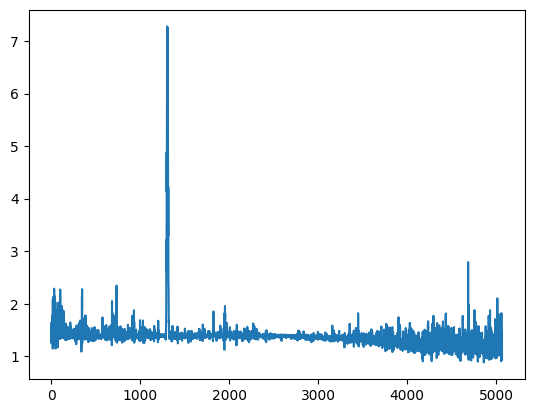

In [33]:
plt.plot(train_losses)

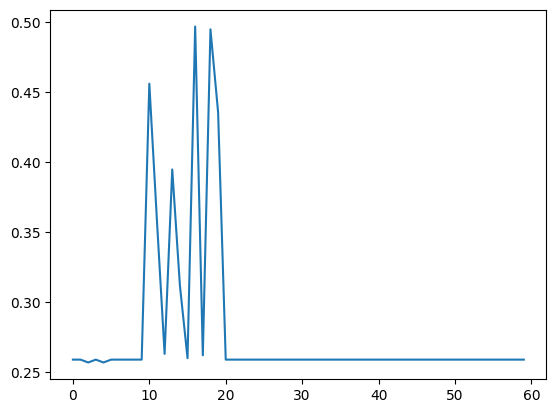

In [34]:
plt.plot(test_accuracy)

In [35]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 254/976 (0.2602)
{'acc_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2602, device='cuda:0'),
 'f1s_detail': tensor([0.4130, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'f1s_unweighted': tensor(0.1033, device='cuda:0'),
 'f1s_weighted': tensor(0.1075, device='cuda:0'),
 'precision_detail': tensor([0.2602, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'rocauc': tensor(0.5002, device='cuda:0'),
 'rocauc_detail': tensor([0.4833, 0.5064, 0.4711, 0.5401], device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0677, device='cuda:0')}


tensor([[254,   0,   0,   0],
        [216,   0,   0,   0],
        [254,   0,   0,   0],
        [252,   0,   0,   0]], device='cuda:0')

In [36]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m14sinc_best_17epoch.pt
Correct: 487/976 (0.4990)
{'acc_detail': tensor([0.7520, 0.0000, 0.9528, 0.2143], device='cuda:0'),
 'acc_unweighted': tensor(0.4798, device='cuda:0'),
 'acc_weighted': tensor(0.4990, device='cuda:0'),
 'f1s_detail': tensor([0.7290, 0.0000, 0.5741, 0.2927], device='cuda:0'),
 'f1s_unweighted': tensor(0.3990, device='cuda:0'),
 'f1s_weighted': tensor(0.4147, device='cuda:0'),
 'precision_detail': tensor([0.7074, 0.0000, 0.4109, 0.4615], device='cuda:0'),
 'recall_detail': tensor([0.7520, 0.0000, 0.9528, 0.2143], device='cuda:0'),
 'rocauc': tensor(0.8145, device='cuda:0'),
 'rocauc_detail': tensor([0.9061, 0.7554, 0.8816, 0.7149], device='cuda:0'),
 'uar': tensor(0.4798, device='cuda:0'),
 'wap': tensor(0.4102, device='cuda:0')}


tensor([[191,   0,  35,  28],
        [  2,   0, 186,  28],
        [  5,   0, 242,   7],
        [ 72,   0, 126,  54]], device='cuda:0')

In [37]:
checkpoint_path = f'../models_cremad4/cremad4_m14sinc_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [38]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                               | 0.003278688524590164/40 [00:00<1:22:54, 124.37s/it]

Train Epoch: 61 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 27369472 3978712064 30543872


  0%|                                | 0.13442622950819672/40 [00:15<1:23:27, 125.62s/it]

Train Epoch: 61 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3856113664 30977024


  1%|▏                               | 0.26557377049180286/40 [00:32<1:34:34, 142.80s/it]

Train Epoch: 61 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3984652288 31425536


  1%|▎                                  | 0.39672131147541/40 [00:51<1:34:10, 142.67s/it]

Train Epoch: 61 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3984652288 31425536


  1%|▍                                | 0.5278688524590167/40 [01:09<1:16:44, 116.64s/it]

Train Epoch: 61 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 31425536 3983446016 30543872


  2%|▌                                | 0.6590163934426216/40 [01:25<1:19:20, 121.00s/it]

Train Epoch: 61 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3983811584 30543872


  2%|▋                                | 0.7901639344262266/40 [01:43<1:34:30, 144.61s/it]

Train Epoch: 61 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30543872 3981636608 30598656


  2%|▉                                   | 0.9999999999999944/40 [01:58<43:37, 67.12s/it]


Test Epoch: 61	Accuracy: 254/976 (26%)



  3%|▉                                   | 1.0032786885245846/40 [01:58<54:42, 84.16s/it]

Train Epoch: 62 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981884928 30543872


  3%|▉                                | 1.1344262295081895/40 [02:17<1:38:46, 152.49s/it]

Train Epoch: 62 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3981157376 30543872


  3%|█                                | 1.2655737704917944/40 [02:33<1:15:14, 116.55s/it]

Train Epoch: 62 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3983811584 30543872


  3%|█▏                               | 1.3967213114753994/40 [02:50<1:15:24, 117.20s/it]

Train Epoch: 62 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3983811584 30543872


  4%|█▎                               | 1.5278688524590043/40 [03:08<1:21:25, 127.00s/it]

Train Epoch: 62 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30598656 3983553536 30543872


  4%|█▎                               | 1.6590163934426092/40 [03:26<1:31:24, 143.04s/it]

Train Epoch: 62 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


  4%|█▍                               | 1.7901639344262141/40 [03:43<1:18:57, 123.99s/it]

Train Epoch: 62 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 31425536 3985209344 31425536


  5%|█▊                                   | 1.999999999999982/40 [03:58<42:46, 67.55s/it]


Test Epoch: 62	Accuracy: 254/976 (26%)



  5%|█▊                                  | 2.0032786885245724/40 [03:59<52:58, 83.64s/it]

Train Epoch: 63 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981947392 30543872


  5%|█▊                               | 2.1344262295081773/40 [04:16<1:29:38, 142.03s/it]

Train Epoch: 63 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3926507008 30543872


  6%|█▉                                | 2.265573770491782/40 [04:32<1:24:17, 134.02s/it]

Train Epoch: 63 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3982867968 30543872


  6%|██                                | 2.396721311475387/40 [04:50<1:30:21, 144.17s/it]

Train Epoch: 63 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 31425536 3986749440 31425536


  6%|██▏                               | 2.527868852458992/40 [05:08<1:29:27, 143.25s/it]

Train Epoch: 63 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 31425536 3984327680 30543872


  7%|██▎                               | 2.659016393442597/40 [05:26<1:28:57, 142.94s/it]

Train Epoch: 63 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 31425536 3984652288 31425536


  7%|██▎                               | 2.790163934426202/40 [05:44<1:29:10, 143.80s/it]

Train Epoch: 63 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


  7%|██▊                                   | 2.99999999999997/40 [05:59<40:59, 66.46s/it]


Test Epoch: 63	Accuracy: 254/976 (26%)



  8%|██▊                                   | 3.00327868852456/40 [06:00<50:41, 82.20s/it]

Train Epoch: 64 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981884928 30543872


  8%|██▋                               | 3.134426229508165/40 [06:18<1:27:24, 142.26s/it]

Train Epoch: 64 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3984003072 30543872


  8%|██▊                                | 3.26557377049177/40 [06:36<1:27:08, 142.32s/it]

Train Epoch: 64 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


  8%|██▊                              | 3.3967213114753747/40 [06:53<1:10:37, 115.76s/it]

Train Epoch: 64 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3983812096 30544384


  9%|██▉                              | 3.5278688524589796/40 [07:10<1:11:17, 117.29s/it]

Train Epoch: 64 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


  9%|███                              | 3.6590163934425846/40 [07:26<1:19:11, 130.76s/it]

Train Epoch: 64 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3984652288 31425536


  9%|███▏                             | 3.7901639344261895/40 [07:44<1:26:55, 144.02s/it]

Train Epoch: 64 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 10%|███▌                                | 3.9999999999999574/40 [07:59<40:18, 67.19s/it]


Test Epoch: 64	Accuracy: 254/976 (26%)



 10%|███▌                                | 4.0032786885245475/40 [07:59<49:44, 82.90s/it]

Train Epoch: 65 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981947392 30543872


 10%|███▌                              | 4.134426229508152/40 [08:17<1:25:18, 142.73s/it]

Train Epoch: 65 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3984003072 30543872


 11%|███▋                              | 4.265573770491757/40 [08:36<1:26:38, 145.47s/it]

Train Epoch: 65 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 31425536 3984652288 31425536


 11%|███▋                              | 4.396721311475362/40 [08:53<1:19:53, 134.64s/it]

Train Epoch: 65 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3985209344 31425536


 11%|███▊                              | 4.527868852458967/40 [09:09<1:21:36, 138.05s/it]

Train Epoch: 65 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3984560128 30543872


 12%|███▉                              | 4.659016393442572/40 [09:26<1:21:33, 138.47s/it]

Train Epoch: 65 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 31425536 3651533312 30543872


 12%|████                              | 4.790163934426177/40 [09:43<1:25:46, 146.16s/it]

Train Epoch: 65 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30543872 3982867968 30543872


 12%|████▌                                | 4.999999999999945/40 [09:58<39:07, 67.07s/it]


Test Epoch: 65	Accuracy: 254/976 (26%)



 13%|████▋                                | 5.003278688524535/40 [09:58<48:39, 83.41s/it]

Train Epoch: 66 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981884928 30543872


 13%|████▍                              | 5.13442622950814/40 [10:16<1:23:34, 143.83s/it]

Train Epoch: 66 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3986100224 30543872


 13%|████▍                             | 5.265573770491745/40 [10:35<1:11:47, 124.00s/it]

Train Epoch: 66 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3983811584 30543872


 13%|████▋                              | 5.39672131147535/40 [10:52<1:23:19, 144.49s/it]

Train Epoch: 66 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3775483904 30543872


 14%|████▋                             | 5.527868852458955/40 [11:10<1:23:53, 146.03s/it]

Train Epoch: 66 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3981780992 30543872


 14%|████▉                              | 5.65901639344256/40 [11:29<1:23:37, 146.11s/it]

Train Epoch: 66 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3981894144 30543872


 14%|████▉                             | 5.790163934426165/40 [11:47<1:31:14, 160.02s/it]

Train Epoch: 66 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30598656 3981456384 30543872


 15%|█████▍                              | 5.9999999999999325/40 [12:02<38:04, 67.18s/it]


Test Epoch: 66	Accuracy: 254/976 (26%)



 15%|█████▌                               | 6.003278688524523/40 [12:02<46:36, 82.24s/it]

Train Epoch: 67 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981947904 30544384


 15%|█████                            | 6.1344262295081275/40 [12:19<1:19:23, 140.66s/it]

Train Epoch: 67 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3652176896 30543872


 16%|█████▏                           | 6.2655737704917325/40 [12:36<1:19:44, 141.84s/it]

Train Epoch: 67 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3984003072 30543872


 16%|█████▍                            | 6.396721311475337/40 [12:54<1:20:07, 143.08s/it]

Train Epoch: 67 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3986424832 30543872


 16%|█████▌                            | 6.527868852458942/40 [13:11<1:04:50, 116.22s/it]

Train Epoch: 67 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3983616000 30543872


 17%|█████▋                            | 6.659016393442547/40 [13:28<1:18:43, 141.67s/it]

Train Epoch: 67 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 31425536 3984652288 31425536


 17%|█████▊                            | 6.790163934426152/40 [13:45<1:18:13, 141.33s/it]

Train Epoch: 67 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 31425536 3984327680 30543872


 17%|██████▋                               | 6.99999999999992/40 [13:59<35:53, 65.26s/it]


Test Epoch: 67	Accuracy: 254/976 (26%)



 18%|██████▋                               | 7.00327868852451/40 [14:00<44:53, 81.63s/it]

Train Epoch: 68 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981884928 30543872


 18%|██████                            | 7.134426229508115/40 [14:17<1:03:31, 115.98s/it]

Train Epoch: 68 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3983812096 30544384


 18%|██████▎                            | 7.26557377049172/40 [14:32<1:16:05, 139.47s/it]

Train Epoch: 68 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3986100224 30543872


 18%|██████▎                           | 7.396721311475325/40 [14:51<1:17:54, 143.37s/it]

Train Epoch: 68 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3985209344 31425536


 19%|██████▌                            | 7.52786885245893/40 [15:08<1:16:41, 141.71s/it]

Train Epoch: 68 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3816872448 30543872


 19%|██████▌                           | 7.659016393442535/40 [15:26<1:18:00, 144.73s/it]

Train Epoch: 68 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 31186432 3982743040 30543872


 19%|██████▊                            | 7.79016393442614/40 [15:44<1:16:12, 141.95s/it]

Train Epoch: 68 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 31425536 3985867776 30543872


 20%|███████▍                             | 7.999999999999908/40 [15:59<35:27, 66.48s/it]


Test Epoch: 68	Accuracy: 254/976 (26%)



 20%|███████▍                             | 8.003278688524498/40 [15:59<43:51, 82.24s/it]

Train Epoch: 69 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981884928 30543872


 20%|██████▉                           | 8.134426229508103/40 [16:17<1:16:22, 143.80s/it]

Train Epoch: 69 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 31425536 3984652288 31425536


 21%|███████                           | 8.265573770491708/40 [16:34<1:14:16, 140.42s/it]

Train Epoch: 69 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3986100224 30543872


 21%|███████▏                          | 8.396721311475313/40 [16:51<1:14:40, 141.77s/it]

Train Epoch: 69 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3986981888 30543872


 21%|███████▏                          | 8.527868852458917/40 [17:10<1:18:37, 149.90s/it]

Train Epoch: 69 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3601572864 30543872


 22%|███████▎                          | 8.659016393442522/40 [17:28<1:15:09, 143.88s/it]

Train Epoch: 69 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 22%|███████▉                            | 8.790163934426127/40 [17:44<58:20, 112.16s/it]

Train Epoch: 69 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30543872 3926265344 30543872


 22%|████████▎                            | 8.999999999999895/40 [17:59<34:14, 66.29s/it]


Test Epoch: 69	Accuracy: 254/976 (26%)



 23%|████████▎                            | 9.003278688524485/40 [17:59<42:35, 82.44s/it]

Train Epoch: 70 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981885440 30543872


 23%|███████▉                           | 9.13442622950809/40 [18:17<1:13:49, 143.49s/it]

Train Epoch: 70 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3984003072 30543872


 23%|████████▎                           | 9.265573770491695/40 [18:33<59:18, 115.77s/it]

Train Epoch: 70 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30544384 3983812096 30543872


 23%|████████▍                           | 9.3967213114753/40 [18:51<1:12:27, 142.07s/it]

Train Epoch: 70 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3984003072 30543872


 24%|████████                          | 9.527868852458905/40 [19:09<1:12:37, 143.00s/it]

Train Epoch: 70 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3984003072 30543872


 24%|████████▍                          | 9.65901639344251/40 [19:28<1:12:24, 143.19s/it]

Train Epoch: 70 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 24%|████████▎                         | 9.790163934426115/40 [19:45<1:07:51, 134.76s/it]

Train Epoch: 70 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30543872 3982867968 30543872


 25%|█████████▏                           | 9.999999999999883/40 [20:00<32:51, 65.71s/it]


Test Epoch: 70	Accuracy: 254/976 (26%)



 25%|█████████                           | 10.003278688524473/40 [20:01<40:54, 81.83s/it]

Train Epoch: 71 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981947392 30543872


 25%|████████▊                          | 10.134426229508078/40 [20:16<57:46, 116.06s/it]

Train Epoch: 71 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 26%|████████▍                        | 10.265573770491683/40 [20:33<1:06:55, 135.06s/it]

Train Epoch: 71 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3984003072 30543872


 26%|█████████                          | 10.396721311475288/40 [20:50<59:32, 120.67s/it]

Train Epoch: 71 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3983811584 30543872


 26%|████████▋                        | 10.527868852458893/40 [21:08<1:10:17, 143.09s/it]

Train Epoch: 71 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 31425536 3984652288 31425536


 27%|████████▊                        | 10.659016393442498/40 [21:24<1:01:38, 126.07s/it]

Train Epoch: 71 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3984884736 30543872


 27%|█████████▍                         | 10.790163934426102/40 [21:41<59:36, 122.43s/it]

Train Epoch: 71 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 31425536 3984652288 31425536


 27%|██████████▏                          | 10.99999999999987/40 [21:55<32:21, 66.95s/it]


Test Epoch: 71	Accuracy: 254/976 (26%)



 28%|██████████▏                          | 11.00327868852446/40 [21:56<40:04, 82.93s/it]

Train Epoch: 72 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981947392 30543872


 28%|█████████▏                       | 11.134426229508065/40 [22:12<1:00:10, 125.09s/it]

Train Epoch: 72 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 28%|█████████▌                        | 11.26557377049167/40 [22:28<1:00:55, 127.23s/it]

Train Epoch: 72 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3817610240 30543872


 28%|█████████▉                         | 11.396721311475275/40 [22:45<55:37, 116.67s/it]

Train Epoch: 72 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3983811584 30543872


 29%|█████████▊                        | 11.52786885245888/40 [23:02<1:05:47, 138.63s/it]

Train Epoch: 72 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3855343104 30543872


 29%|█████████▌                       | 11.659016393442485/40 [23:21<1:08:42, 145.45s/it]

Train Epoch: 72 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3985209344 31425536


 29%|██████████                        | 11.79016393442609/40 [23:40<1:08:39, 146.05s/it]

Train Epoch: 72 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 31425536 3985209344 31425536


 30%|██████████▊                         | 11.999999999999858/40 [23:54<31:33, 67.63s/it]


Test Epoch: 72	Accuracy: 254/976 (26%)



 30%|██████████▊                         | 12.003278688524448/40 [23:55<38:44, 83.04s/it]

Train Epoch: 73 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981947392 30543872


 30%|██████████                       | 12.134426229508053/40 [24:12<1:06:21, 142.87s/it]

Train Epoch: 73 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3984003072 30543872


 31%|██████████                       | 12.265573770491658/40 [24:30<1:07:16, 145.55s/it]

Train Epoch: 73 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30598656 3981884928 30543872


 31%|██████████▏                      | 12.396721311475263/40 [24:46<1:03:48, 138.68s/it]

Train Epoch: 73 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3986100224 30543872


 31%|██████████▎                      | 12.527868852458868/40 [25:04<1:05:07, 142.25s/it]

Train Epoch: 73 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 32%|██████████▍                      | 12.659016393442473/40 [25:23<1:05:36, 143.96s/it]

Train Epoch: 73 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 31425536 3983770624 30543872


 32%|███████████▏                       | 12.790163934426078/40 [25:39<53:14, 117.39s/it]

Train Epoch: 73 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 32%|███████████▋                        | 12.999999999999845/40 [25:54<30:02, 66.77s/it]


Test Epoch: 73	Accuracy: 254/976 (26%)



 33%|███████████▋                        | 13.003278688524436/40 [25:55<38:37, 85.85s/it]

Train Epoch: 74 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981884928 30543872


 33%|███████████▏                      | 13.13442622950804/40 [26:12<1:02:02, 138.54s/it]

Train Epoch: 74 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 31425536 3816678912 30543872


 33%|██████████▉                      | 13.265573770491645/40 [26:30<1:04:06, 143.87s/it]

Train Epoch: 74 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 31425536 3983770624 30543872


 33%|███████████▍                      | 13.39672131147525/40 [26:48<1:03:15, 142.69s/it]

Train Epoch: 74 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 34%|███████████▏                     | 13.527868852458855/40 [27:06<1:02:59, 142.78s/it]

Train Epoch: 74 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 34%|████████████▎                       | 13.65901639344246/40 [27:25<56:31, 128.74s/it]

Train Epoch: 74 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30668800 3983887872 30868480


 34%|███████████▍                     | 13.790163934426065/40 [27:43<1:02:36, 143.34s/it]

Train Epoch: 74 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 35%|████████████▌                       | 13.999999999999833/40 [27:58<29:19, 67.67s/it]


Test Epoch: 74	Accuracy: 254/976 (26%)



 35%|████████████▌                       | 14.003278688524423/40 [27:58<35:49, 82.69s/it]

Train Epoch: 75 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981884928 30543872


 35%|███████████▋                     | 14.134426229508028/40 [28:16<1:02:27, 144.89s/it]

Train Epoch: 75 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3985209344 31425536


 36%|████████████▍                      | 14.265573770491633/40 [28:34<49:37, 115.72s/it]

Train Epoch: 75 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3984884736 30543872


 36%|███████████▉                     | 14.396721311475238/40 [28:52<1:02:21, 146.13s/it]

Train Epoch: 75 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3984652288 31425536


 36%|████████████▋                      | 14.527868852458843/40 [29:10<53:49, 126.78s/it]

Train Epoch: 75 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3983940608 30543872


 37%|████████████▊                      | 14.659016393442448/40 [29:26<48:53, 115.75s/it]

Train Epoch: 75 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3983616000 30543872


 37%|████████████▏                    | 14.790163934426053/40 [29:43<1:00:29, 143.97s/it]

Train Epoch: 75 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30543872 3981157376 30543872


 37%|█████████████▊                       | 14.99999999999982/40 [29:58<27:45, 66.63s/it]


Test Epoch: 75	Accuracy: 254/976 (26%)



 38%|█████████████▉                       | 15.00327868852441/40 [29:59<34:30, 82.82s/it]

Train Epoch: 76 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981884928 30543872


 38%|█████████████▏                     | 15.134426229508016/40 [30:15<48:13, 116.38s/it]

Train Epoch: 76 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 38%|█████████████▋                      | 15.26557377049162/40 [30:32<48:20, 117.28s/it]

Train Epoch: 76 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 31425536 3983770624 30543872


 38%|█████████████▍                     | 15.396721311475225/40 [30:48<47:40, 116.26s/it]

Train Epoch: 76 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30563840 3983811584 30543872


 39%|█████████████▏                    | 15.52786885245883/40 [31:06<1:05:17, 160.07s/it]

Train Epoch: 76 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3985209344 31425536


 39%|█████████████▋                     | 15.659016393442435/40 [31:25<55:36, 137.07s/it]

Train Epoch: 76 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3985209344 31425536


 39%|██████████████▏                     | 15.79016393442604/40 [31:41<53:39, 132.98s/it]

Train Epoch: 76 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30543872 3982796800 30543872


 40%|██████████████▍                     | 15.999999999999808/40 [31:56<33:19, 83.30s/it]


Test Epoch: 76	Accuracy: 254/976 (26%)



 40%|███████████████▏                      | 16.0032786885244/40 [31:56<37:11, 92.99s/it]

Train Epoch: 77 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981884928 30543872


 40%|██████████████                     | 16.134426229508076/40 [32:13<56:17, 141.50s/it]

Train Epoch: 77 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3984003072 30543872


 41%|██████████████▏                    | 16.265573770491752/40 [32:31<56:30, 142.84s/it]

Train Epoch: 77 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 41%|██████████████▎                    | 16.396721311475428/40 [32:49<46:02, 117.03s/it]

Train Epoch: 77 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3983811584 30563840


 41%|██████████████▍                    | 16.527868852459104/40 [33:08<54:53, 140.32s/it]

Train Epoch: 77 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3651533312 30543872


 42%|██████████████▉                     | 16.65901639344278/40 [33:24<45:58, 118.19s/it]

Train Epoch: 77 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30868480 3983657984 30543872


 42%|██████████████▋                    | 16.790163934426456/40 [33:40<52:30, 135.75s/it]

Train Epoch: 77 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30668800 3984003072 30543872


 43%|███████████████▎                    | 17.000000000000338/40 [33:55<25:44, 67.15s/it]


Test Epoch: 77	Accuracy: 254/976 (26%)



 43%|███████████████▋                     | 17.00327868852493/40 [33:55<31:53, 83.21s/it]

Train Epoch: 78 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981884928 30543872


 43%|██████████████▉                    | 17.134426229508605/40 [34:12<45:01, 118.16s/it]

Train Epoch: 78 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3983812096 30544384


 43%|███████████████▌                    | 17.26557377049228/40 [34:30<55:06, 145.43s/it]

Train Epoch: 78 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 31425536 3984327680 30543872


 43%|███████████████▏                   | 17.396721311475957/40 [34:47<45:49, 121.66s/it]

Train Epoch: 78 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3983874048 30563840


 44%|███████████████▎                   | 17.527868852459633/40 [35:02<46:14, 123.48s/it]

Train Epoch: 78 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3983678464 30543872


 44%|███████████████▉                    | 17.65901639344331/40 [35:19<43:11, 116.00s/it]

Train Epoch: 78 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3984003072 30543872


 44%|███████████████▌                   | 17.790163934426985/40 [35:36<52:31, 141.88s/it]

Train Epoch: 78 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 45%|████████████████▏                   | 18.000000000000867/40 [35:51<24:37, 67.18s/it]


Test Epoch: 78	Accuracy: 254/976 (26%)



 45%|████████████████▋                    | 18.00327868852546/40 [35:52<30:27, 83.08s/it]

Train Epoch: 79 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981884928 30543872


 45%|███████████████▊                   | 18.134426229509135/40 [36:10<50:48, 139.42s/it]

Train Epoch: 79 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3982867968 30543872


 46%|████████████████▍                   | 18.26557377049281/40 [36:27<51:45, 142.90s/it]

Train Epoch: 79 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 46%|████████████████                   | 18.396721311476487/40 [36:45<50:45, 140.95s/it]

Train Epoch: 79 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3775668736 30543872


 46%|████████████████▏                  | 18.527868852460163/40 [37:03<44:38, 124.76s/it]

Train Epoch: 79 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3983940608 30543872


 47%|████████████████▊                   | 18.65901639344384/40 [37:21<50:26, 141.81s/it]

Train Epoch: 79 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 47%|████████████████▍                  | 18.790163934427515/40 [37:38<41:13, 116.60s/it]

Train Epoch: 79 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 31425536 3985586176 31425536


 48%|█████████████████                   | 19.000000000001396/40 [37:52<23:04, 65.92s/it]


Test Epoch: 79	Accuracy: 254/976 (26%)



 48%|█████████████████                   | 19.003278688525988/40 [37:53<29:10, 83.37s/it]

Train Epoch: 80 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981947392 30543872


 48%|████████████████▋                  | 19.134426229509664/40 [38:09<41:05, 118.18s/it]

Train Epoch: 80 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3984003072 30543872


 48%|█████████████████▎                  | 19.26557377049334/40 [38:26<49:41, 143.77s/it]

Train Epoch: 80 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 31425536 3984652288 31425536


 48%|████████████████▉                  | 19.396721311477016/40 [38:44<40:02, 116.59s/it]

Train Epoch: 80 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3983811584 30543872


 49%|█████████████████                  | 19.527868852460692/40 [39:02<49:49, 146.02s/it]

Train Epoch: 80 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30868480 3984652288 31425536


 49%|█████████████████▏                 | 19.659016393444368/40 [39:20<39:48, 117.44s/it]

Train Epoch: 80 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3983812096 30544384


 49%|█████████████████▎                 | 19.790163934428044/40 [39:37<48:23, 143.67s/it]

Train Epoch: 80 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30543872 3983970304 30543872


 50%|██████████████████                  | 20.000000000001926/40 [39:52<22:36, 67.82s/it]


Test Epoch: 80	Accuracy: 254/976 (26%)



 50%|██████████████████                  | 20.003278688526517/40 [39:53<28:01, 84.07s/it]

Train Epoch: 81 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981884928 30543872


 50%|█████████████████▌                 | 20.134426229510193/40 [40:10<42:10, 127.37s/it]

Train Epoch: 81 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 31425536 3984652288 31425536


 51%|██████████████████▏                 | 20.26557377049387/40 [40:28<48:01, 146.02s/it]

Train Epoch: 81 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 51%|█████████████████▊                 | 20.396721311477545/40 [40:45<38:49, 118.81s/it]

Train Epoch: 81 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3983812096 30544384


 51%|██████████████████▍                 | 20.52786885246122/40 [41:04<46:29, 143.24s/it]

Train Epoch: 81 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 52%|██████████████████                 | 20.659016393444897/40 [41:22<41:34, 128.98s/it]

Train Epoch: 81 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 52%|██████████████████▏                | 20.790163934428573/40 [41:39<37:32, 117.26s/it]

Train Epoch: 81 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 31425536 3984652288 31425536


 53%|██████████████████▉                 | 21.000000000002455/40 [41:54<21:55, 69.23s/it]


Test Epoch: 81	Accuracy: 254/976 (26%)



 53%|██████████████████▉                 | 21.003278688527047/40 [41:54<26:25, 83.48s/it]

Train Epoch: 82 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981947392 30543872


 53%|██████████████████▍                | 21.134426229510723/40 [42:11<40:31, 128.87s/it]

Train Epoch: 82 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30598656 3983878144 30543872


 53%|███████████████████▋                 | 21.2655737704944/40 [42:27<36:23, 116.57s/it]

Train Epoch: 82 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3984003072 30543872


 53%|██████████████████▋                | 21.396721311478075/40 [42:43<40:16, 129.91s/it]

Train Epoch: 82 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3983940608 30543872


 54%|███████████████████▍                | 21.52786885246175/40 [43:02<43:35, 141.60s/it]

Train Epoch: 82 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 30543872 3984003072 30543872


 54%|██████████████████▉                | 21.659016393445427/40 [43:18<42:09, 137.91s/it]

Train Epoch: 82 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3982867968 30543872


 54%|███████████████████                | 21.790163934429103/40 [43:33<35:25, 116.71s/it]

Train Epoch: 82 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30543872 3984003072 30543872


 55%|███████████████████▊                | 22.000000000002984/40 [43:48<20:12, 67.37s/it]


Test Epoch: 82	Accuracy: 254/976 (26%)



 55%|███████████████████▊                | 22.003278688527576/40 [43:48<24:57, 83.21s/it]

Train Epoch: 83 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981884928 30543872


 55%|███████████████████▎               | 22.134426229511252/40 [44:06<43:09, 144.94s/it]

Train Epoch: 83 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 56%|████████████████████                | 22.26885245901952/40 [44:24<34:40, 117.32s/it]

Train Epoch: 83 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3986981888 30543872


 56%|███████████████████▌               | 22.396721311478604/40 [44:42<36:46, 125.37s/it]

Train Epoch: 83 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 31425536 3984652288 31425536


 56%|████████████████████▎               | 22.52786885246228/40 [45:00<37:56, 130.27s/it]

Train Epoch: 83 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 31425536 3983770624 30543872


 57%|███████████████████▊               | 22.659016393445956/40 [45:17<39:08, 135.44s/it]

Train Epoch: 83 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3985218560 30543872


 57%|███████████████████▉               | 22.790163934429632/40 [45:35<38:50, 135.39s/it]

Train Epoch: 83 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 30543872 3900226560 30593024


 58%|████████████████████▋               | 23.000000000003514/40 [45:50<19:03, 67.24s/it]


Test Epoch: 83	Accuracy: 254/976 (26%)



 58%|████████████████████▋               | 23.003278688528106/40 [45:50<23:35, 83.28s/it]

Train Epoch: 84 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981884928 30543872


 58%|████████████████████▊               | 23.13442622951178/40 [46:08<40:15, 143.24s/it]

Train Epoch: 84 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 31425536 3984652288 31425536


 58%|████████████████████▎              | 23.265573770495457/40 [46:26<41:28, 148.70s/it]

Train Epoch: 84 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3980645888 30543872


 58%|████████████████████▍              | 23.396721311479133/40 [46:43<40:07, 144.99s/it]

Train Epoch: 84 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3984884736 30543872


 59%|█████████████████████▏              | 23.52786885246281/40 [47:01<43:36, 158.81s/it]

Train Epoch: 84 [2560/3918 (66%)]	Loss: nan
Mem before-during-after: 31425536 3983770624 30543872


 59%|████████████████████▋              | 23.659016393446485/40 [47:18<31:28, 115.55s/it]

Train Epoch: 84 [3200/3918 (82%)]	Loss: nan
Mem before-during-after: 30543872 3983811584 30543872


 59%|█████████████████████▍              | 23.79016393443016/40 [47:36<39:09, 144.96s/it]

Train Epoch: 84 [3840/3918 (98%)]	Loss: nan
Mem before-during-after: 31425536 3984327680 30543872


 60%|█████████████████████▌              | 24.000000000004043/40 [47:51<23:35, 88.48s/it]


Test Epoch: 84	Accuracy: 254/976 (26%)



 60%|█████████████████████▌              | 24.003278688528635/40 [47:51<25:51, 96.97s/it]

Train Epoch: 85 [0/3918 (0%)]	Loss: nan
Mem before-during-after: 30542848 3981884928 30543872


 60%|█████████████████████▋              | 24.13442622951231/40 [48:06<30:38, 115.85s/it]

Train Epoch: 85 [640/3918 (16%)]	Loss: nan
Mem before-during-after: 30543872 3983811584 30543872


 61%|█████████████████████▏             | 24.265573770495987/40 [48:24<37:42, 143.79s/it]

Train Epoch: 85 [1280/3918 (33%)]	Loss: nan
Mem before-during-after: 30543872 3984327680 30543872


 61%|█████████████████████▎             | 24.396721311479663/40 [48:43<35:58, 138.31s/it]

Train Epoch: 85 [1920/3918 (49%)]	Loss: nan
Mem before-during-after: 30543872 3855520256 30543872


 61%|██████████████████████              | 24.49508196721742/40 [48:57<30:59, 119.91s/it]

KeyboardInterrupt



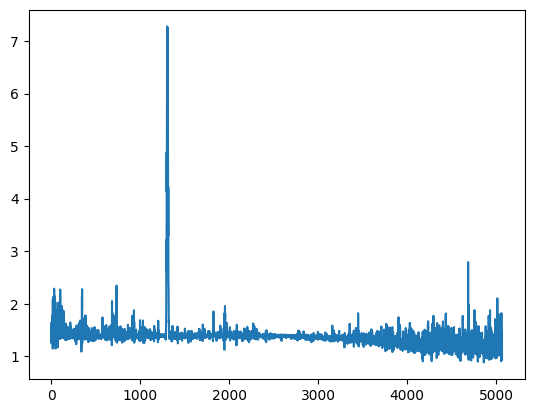

In [39]:
plt.plot(train_losses)

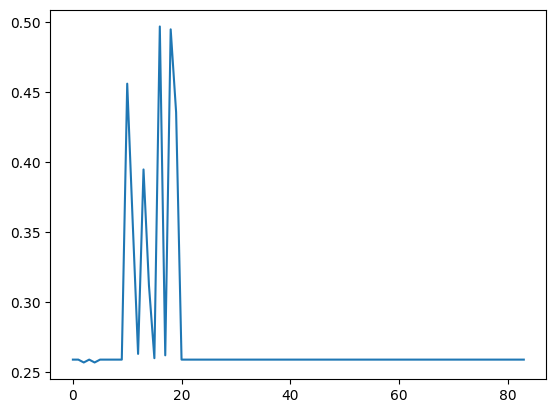

In [40]:
plt.plot(test_accuracy)

In [41]:
checkpoint_path = f'../models_cremad4/cremad4_m14sinc_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [42]:
model

M13sinc(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (no

In [43]:
from IConNet.visualizer import display_module

/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert filters.shape[1] == self.in_channels
/home/linh/projects/IConNet/IConNet/conv/pad.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if residual <= 0:
/home/linh/projects/IConNet/IConNet/conv/longconv.py:86: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not ge

aten::mean %x : Float(1, 229, strides=[229, 1], requires_grad=1, device=cuda:0) = aten::mean(%1300, %1149, %1150, %1151) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



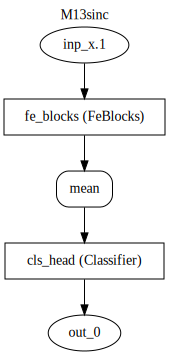

In [44]:
input_shape = (1,1,16000)
best_model.to(device)
input = torch.rand(input_shape).to(device)
display_module(
    model, input, 
    classes_to_visit={})

/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert filters.shape[1] == self.in_channels
/home/linh/projects/IConNet/IConNet/conv/pad.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if residual <= 0:
/home/linh/projects/IConNet/IConNet/conv/longconv.py:86: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not ge

aten::mean %x : Float(1, 229, strides=[229, 1], requires_grad=1, device=cuda:0) = aten::mean(%1300, %1149, %1150, %1151) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



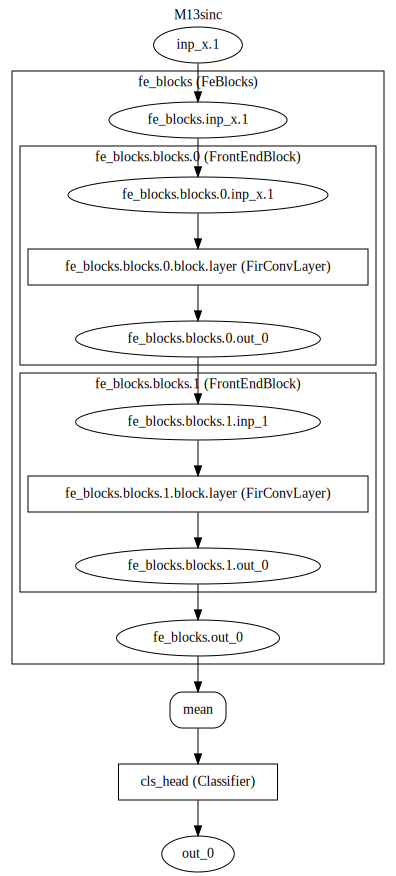

In [45]:
display_module(
    best_model, input, 
    classes_to_visit={"FeBlocks", "FrontEndBlock"})

/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert filters.shape[1] == self.in_channels
/home/linh/projects/IConNet/IConNet/conv/pad.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if residual <= 0:
/home/linh/projects/IConNet/IConNet/conv/longconv.py:86: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not ge

aten::mean %x : Float(1, 229, strides=[229, 1], requires_grad=1, device=cuda:0) = aten::mean(%1300, %1149, %1150, %1151) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



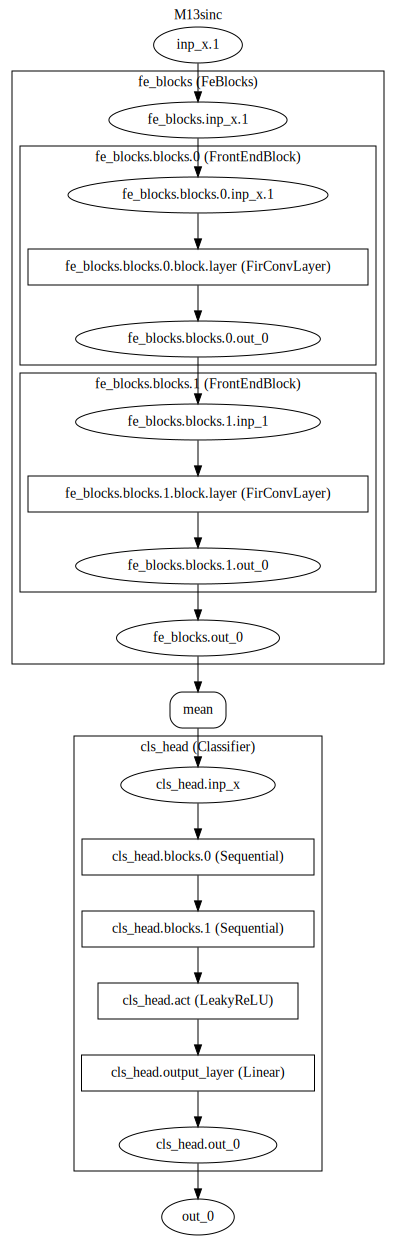

In [46]:
display_module(
    best_model, input, 
    classes_to_visit={"FeBlocks", "FrontEndBlock", "Classifier"})

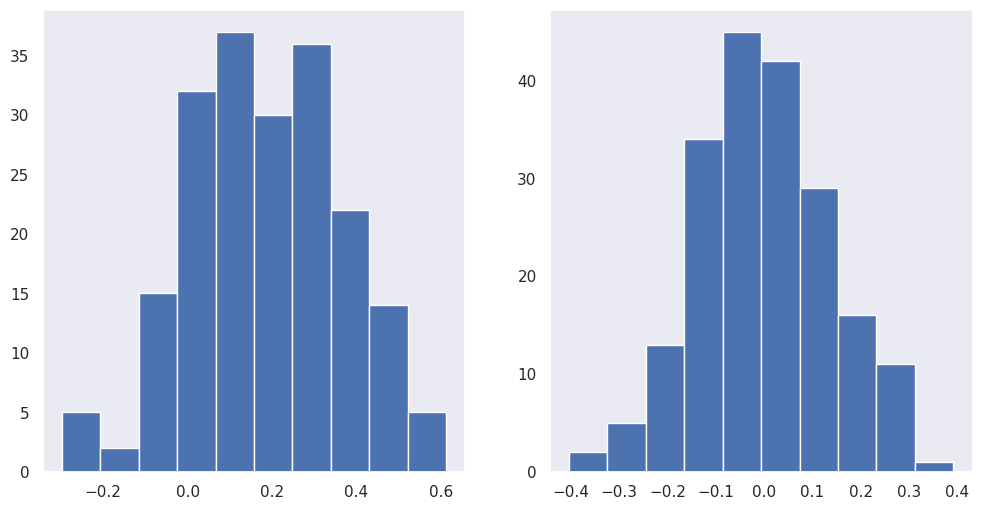

In [50]:
from IConNet.visualizer import visualize_model

layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = None, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

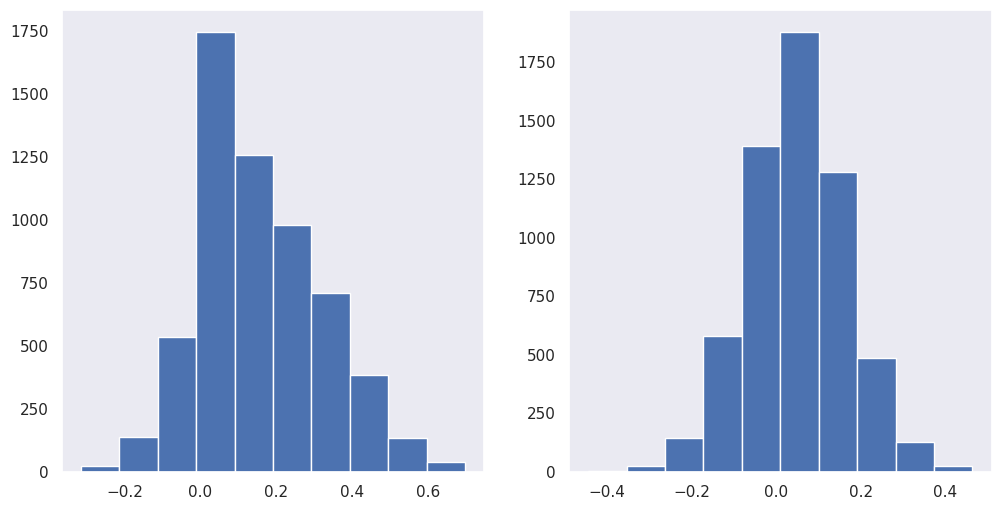

In [51]:
layer2 = best_model.fe_blocks.blocks[1].block.layer

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = None, 
    window_length = 64,
    sample_rate = sr
)
filtviz2.visualize_bands()

In [52]:
del model
del best_model
gc.collect()

19668